# Components

```{glue:figure} NTR_components_stds
:scale: 50%
:align: right
```

In this notebook we'll explore the various contributions to high and low water levels. At the moment this is exploratory - we are using this to take broad stroke looks. We'll do this by breaking down the time series of hourly water levels at a tide gauge into different frequency bands, with the idea that certain processes fall within these timescales. For example, we know that ENSO timescales are roughly 4-7 years. We know that PDO timescales are closer to 20 years, and the timescale of mesoscale eddies the Hawaiian Island archipelago are 3 - 6 months. It's important to keep in mind that in this analysis we are not directly relating any of these processes to the observed sea levels at the tide gauges, but rather we are looking at _variability on similar timescales_. 

Thus, we're breaking sea level down into:

$\eta = \eta_{tide} + \eta_{trend} + \eta_{NTR}$

where

$\eta_{NTR} = \eta_{Decadal} + \eta_{InterAnnual} + \eta_{SubAnnual} + \eta_{Monthly} + \eta_{Weekly} + \eta_{HighFrequency}$

Note that $\eta_{tide}$ here accounts for the nodal cycle modulation, and thus it is absent from the non-tidal residuals.

<!-- # make a dictionary of the timescales and the processes
timeframes = {'Decadal': 'e.g. PDO, 8-30+ yr', 
              'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-8 yr', 
              'Intraannual': 'e.g. Mesoscale eddies', 
              'Weekly': '1 week - 2 months', 
              'Storms': '& other short-term variability',
              'Nodal': '18.6 yr tidal modulation'} -->


## Setup

In [1]:
print('Importing libraries')
%run setup.ipynb
print('Importing plotting rules and functions')
import plotting_functions
print('Importing time series functions')
from tseries_functions import *
from tide_functions import calculate_ntr

Importing libraries
Successfully imported custom functions
Using custom paths from config_env.py
Data directory: /Users/jfiedler/Documents/SL_Hawaii_data/data
Output directory: /Users/jfiedler/Library/CloudStorage/GoogleDrive-jfiedler@hawaii.edu/Shared drives/PI Indicators 2025/SL Indicators/Hawaii_Region_Output
Importing plotting rules and functions
Importing time series functions


## Obtain the Non-tidal Residual (NTR)

First we'll estimate the astronomical tides at our gauge locations using the selected epoch. The tide values are estimated using the python implementation of UTide (pypi.org/project/utide, based off Codiga 2011).

The routine is as follows:

- Detrend the hourly sea level data for 1983-2001 epoch
- Solve for coefficents with no nodal corrections using the detrended data
- Solve for coefficients with nodal corrections using the detrended data
- Reconstruct the full timeseries based on:
    - all coefficients (including nodal, annual, and semi-annual cycles)
    - all coefficients except the nodal cycle
    - all coefficients except the annual and semi-annual cycles

Here, we define the NTR as:

$NTR = SL - T - LT$

where SL is the sea level, T is the predicted tide (including nodal, annual and semi-annual) and LT is the linear trend.

The nodal modulation is the difference between the tidal predictions with and without the nodal corrections applied.

In [2]:
ds = xr.open_dataset(data_dir / 'rsl_hawaii_noaa.nc')

# change all the station_ids to integers
ds['station_id'] = ds['station_id'].astype(int)


# get the ntr for each station
calculate_ntr(ds)

Already processed 28 files:
[1612480, 1617760, 1612340, 1617433, 1617433, 1612340, 1611400, 1617760, 1611400, 1615680, 1611400, 1612480, 1617760, 1612480, 1615680, 1619910, 1619910, 1612340, 1615680, 1615680, 1619910, 1617760, 1619910, 1617433, 1611400, 1617433, 1612480, 1612340]


In [3]:
station_ids = ds['station_id'].values
station_ids

array([1617760, 1619910, 1617433, 1612480, 1615680, 1612340, 1611400])

In [4]:
# load ntr data
station_id = station_ids[6]
print('Doing station', station_id)
station_name = ds.station_name.sel(station_id=station_id).item()
print('Station name:', station_name)
mhhw = ds.MHHW.sel(station_id=station_id).item()
msl = ds.MSL.sel(station_id=station_id).item()
mllw = ds.MLLW.sel(station_id=station_id).item()
ntrpath = f'ntr_data/ntr_{station_id}.csv'


ntr_data = pd.read_csv(Path(data_dir / ntrpath), parse_dates=['time'])

#inspect it, does it look sane?
ntr_data

Doing station 1611400
Station name: Nawiliwili


,time,ntr,ntr_noASA,sea_level,sea_level_detrended,trend,trendDiffEpoch,tide,nodal,ntr_withNodal,seasonal_cycle
0,1954-11-27 10:00:00,0.085718,0.105588,0.884,-0.005977,0.889977,0.063452,-0.091695,-0.003497,0.089215,0.019828
1,1954-11-27 11:00:00,0.074311,0.094149,1.006,0.116022,0.889978,0.063452,0.041711,-0.006498,0.080809,0.019796
2,1954-11-27 12:00:00,0.090504,0.110310,1.158,0.268022,0.889978,0.063452,0.177519,-0.008930,0.099433,0.019764
3,1954-11-27 13:00:00,0.096688,0.116463,1.280,0.390022,0.889978,0.063452,0.293334,-0.010287,0.106975,0.019733
4,1954-11-27 14:00:00,0.111380,0.131124,1.372,0.482022,0.889978,0.063451,0.370642,-0.010638,0.122018,0.019701
...,...,...,...,...,...,...,...,...,...,...,...
614434,2024-12-30 20:00:00,-0.125054,-0.127195,0.798,-0.221641,1.019641,-0.074303,-0.096587,-0.012759,-0.112295,-0.002183
614435,2024-12-30 21:00:00,-0.109395,-0.111559,0.783,-0.236642,1.019642,-0.074303,-0.127247,-0.001777,-0.107617,-0.002206
614436,2024-12-30 22:00:00,-0.068822,-0.071010,0.822,-0.197642,1.019642,-0.074303,-0.128820,0.009893,-0.078715,-0.002230
614437,2024-12-30 23:00:00,-0.027334,-0.029545,0.878,-0.141642,1.019642,-0.074303,-0.114308,0.020396,-0.047730,-0.002253


In the above dataframe, 'ntr_noASA' is the NTR if the Annual and Semi-Annual cycles are also removed, such that:

$NTR = SL - T - LT - ASA$

where SL is the sea level, T is the predicted tide (including nodal, annual and semi-annual), LT is the linear trend, and ASA is the combined Annual and Semi-Annual cycle.

### Take a first look at the data

Text(0.5, 1.0, 'Nawiliwili (1611400)')

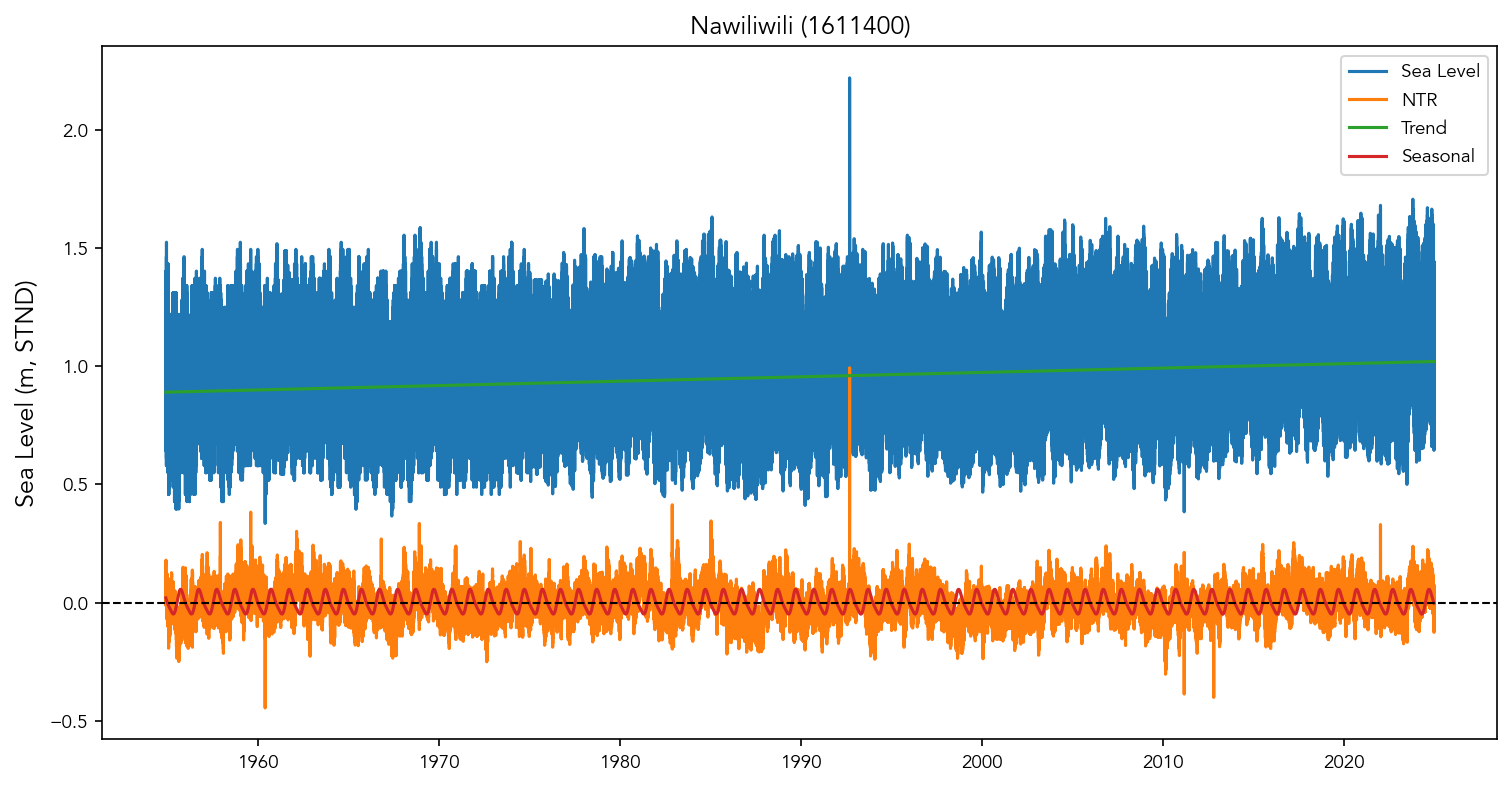

In [5]:
#plot sea level
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ntr_data.time, ntr_data.sea_level, label='Sea Level')
ax.plot(ntr_data.time, ntr_data.ntr , label='NTR')
ax.plot(ntr_data.time, ntr_data.trend, label='Trend')
ax.plot(ntr_data.time, ntr_data.seasonal_cycle, label='Seasonal')

# add zero line
ax.axhline(0, color='k', linestyle='--', lw=1)

# add legend
ax.legend()

# add ylabel
ax.set_ylabel('Sea Level (m, STND)')
ax.set_title(f'{station_name} ({station_id})')


In [6]:
# save the trendDiffEpoch as separate variable - this is going to set all of our tide and NTR values to the right datum (using the chosen epoch, in this case 1983-2001)
trendDiff = ntr_data['trendDiffEpoch']

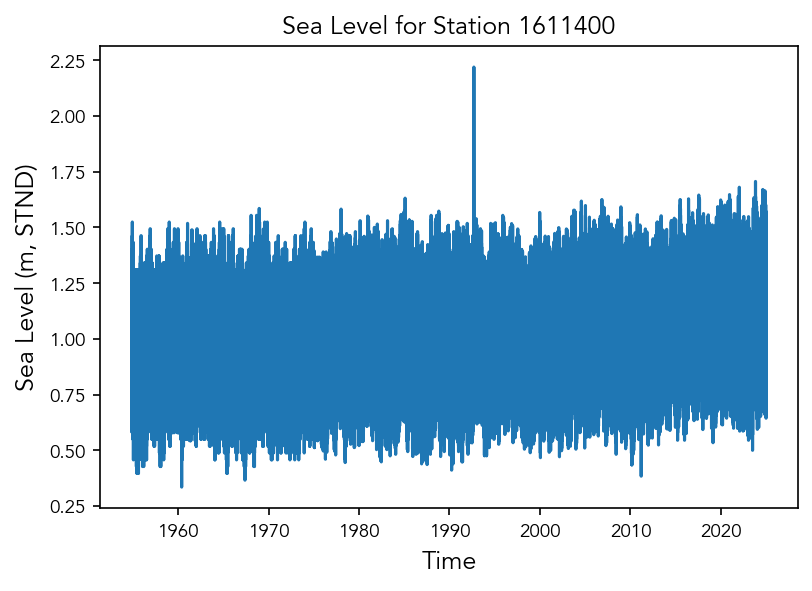

In [7]:
# plot ds['sea_level'] for the station
sid = xr.load_dataset(data_dir/ 'tide_gauge_nc' / f'noaa_{station_id}.nc')
sid['sea_level'].plot()
plt.title(f'Sea Level for Station {station_id}')
plt.xlabel('Time')
plt.ylabel('Sea Level (m, STND)')
plt.show()

Do a quick check to make sure that the tide + NTR is the same as the detrended sea level.

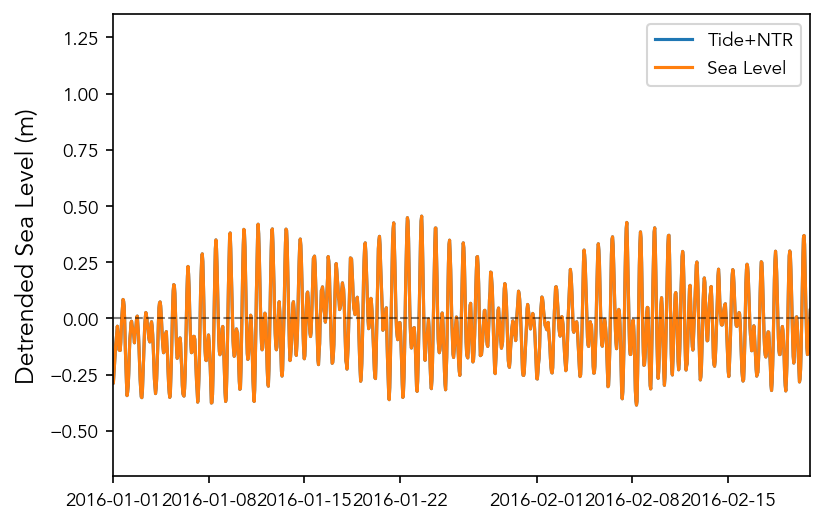

In [8]:
plt.plot(ntr_data['time'], ntr_data.tide + ntr_data.ntr, label='Tide+NTR')
plt.plot(ntr_data['time'], ntr_data.sea_level_detrended, label='Sea Level')

# add dotted zero line
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

#truncate x axis to 2016 only
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-2-21'))

# set ylabel
plt.ylabel('Detrended Sea Level (m)')
plt.legend()

### Plot and Inspect
We're looking at the NTR with and without the nodal modulation removed.

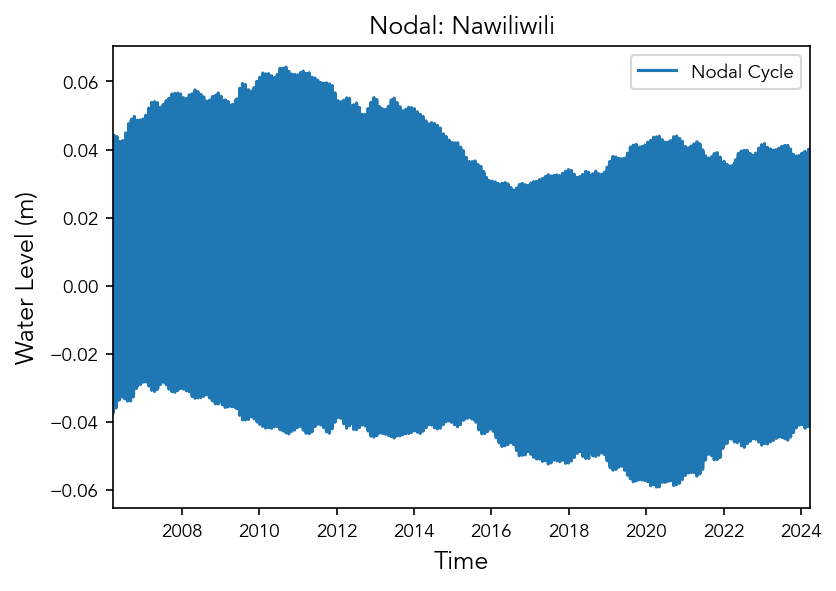

In [9]:
plt.plot(ntr_data['time'], ntr_data['nodal'], label='Nodal Cycle')

# add title
plt.title('Nodal: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Water Level' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2000-2005
plt.xlim([np.datetime64('2006-03-21'), np.datetime64('2024-03-30')])
plt.legend()


## First, let's look at the seasonal cycle
We obtain the seasonal cycle by using the SA and SSA coefficients from the tidal analysis. SA (Solar Annual) and SSA (Solar Semi-Annual) "mostly reflect yearly meteorological variations influencing sea level." [(NOAA Tides and Current Glossay)](https://tidesandcurrents.noaa.gov/glossary.html#S:~:text=per%20solar%20hour.-,Sa,-Solar%20annual%20constituent)

(0.0, 365.0)

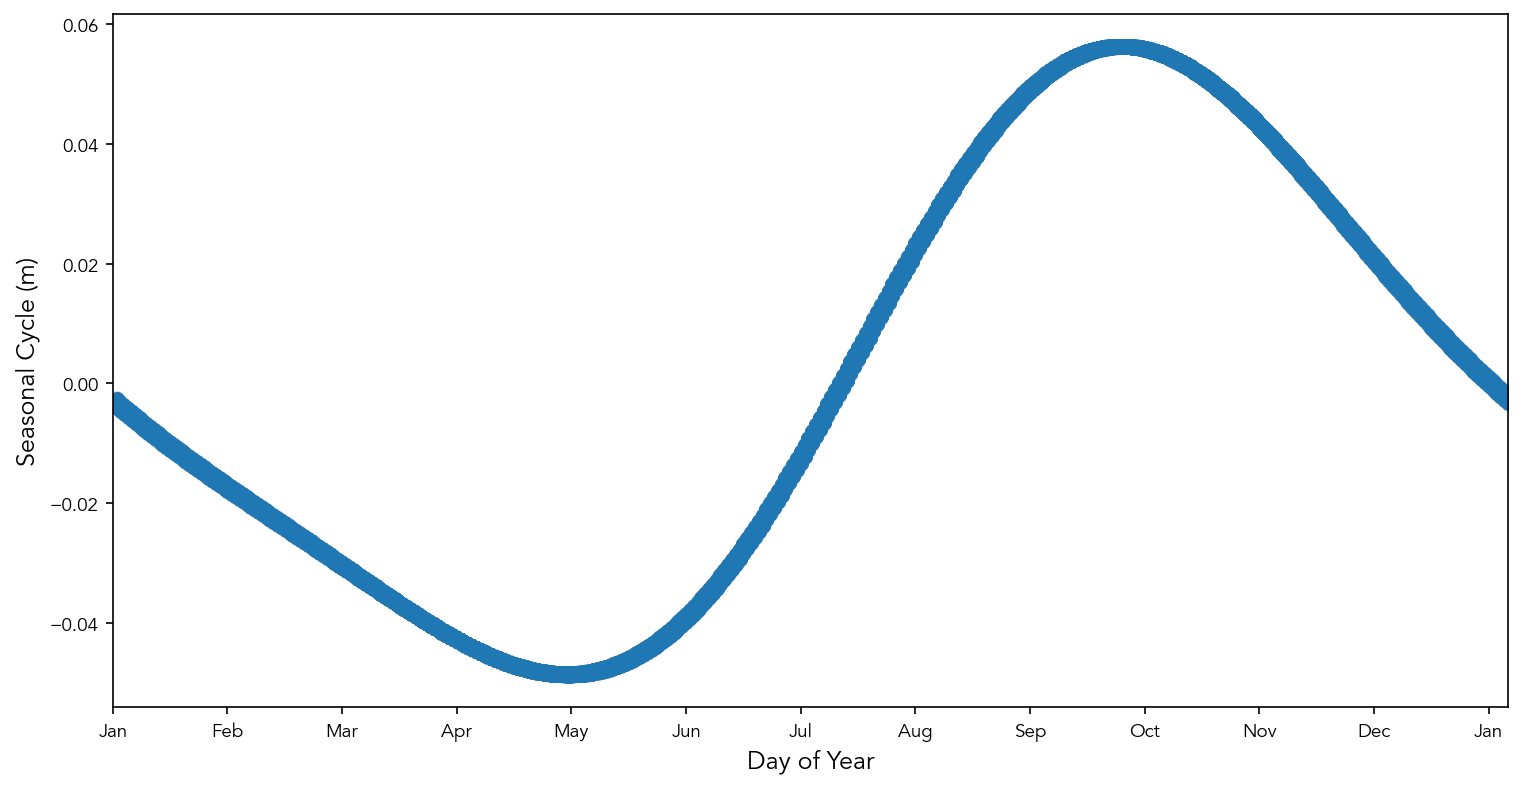

In [10]:
# Step 1, look at the Annual and Semi-annual cycles from UTide
#convert timeseries to day of year
ntr_data['dayofyear'] = ntr_data['time'].dt.dayofyear
#plot time series with day of year
plt.figure(figsize=(12, 6))
plt.scatter(ntr_data['dayofyear'], ntr_data['seasonal_cycle'], label='NTR with Nodal Cycle', alpha=0.05)

# change x-axis to be months
plt.xticks(np.arange(0, 365, 30), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','Jan'])
plt.xlabel('Day of Year')
plt.ylabel('Seasonal Cycle' + ' (' + ds['sea_level'].attrs['units'] + ')')

# set xlim
plt.xlim([0, 365])

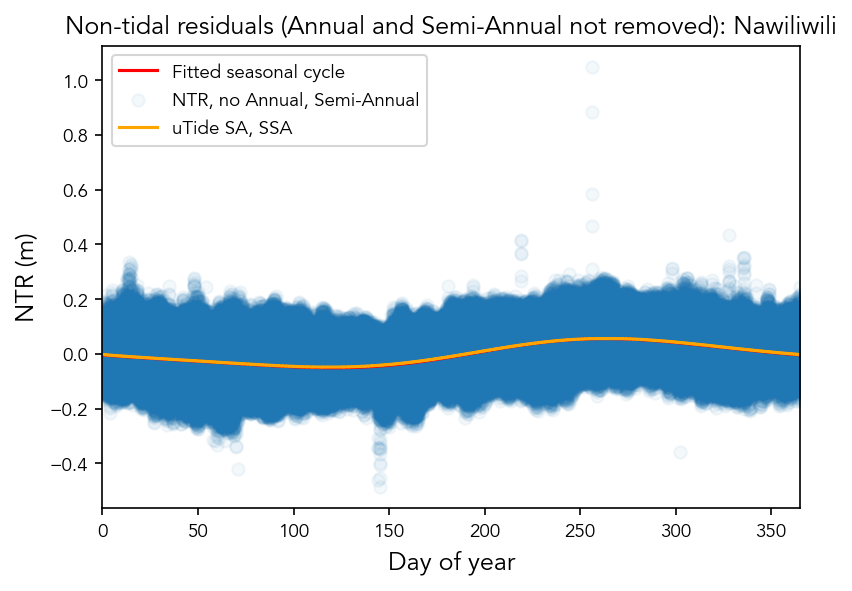

In [11]:
# Fit an annual and semi-annual cycle to the data
from scipy.optimize import curve_fit
from scipy.optimize import minimize
def seasonal_cycle(x, a, b, c, d, e):
    return a * np.sin(2 * np.pi * (x - b) / 365.25) + c * np.sin(2 * np.pi * (x - d) / 182.25) + e


# Remove rows with NaN values in 'ntr' or 'dayofyear'
filtered_data = ntr_data.dropna(subset=['ntr_noASA', 'dayofyear'])

# Fit the seasonal cycle to the filtered data
# Define a function to minimize the absolute deviation (median fitting)
def median_loss(params, x, y):
    return np.sum(np.abs(y - seasonal_cycle(x, *params)))

# Initial guess for the parameters
initial_guess = [1, 1, 1, 1, 1]

# Perform the minimization
result = minimize(median_loss, initial_guess, args=(filtered_data['dayofyear'], filtered_data['ntr_noASA']))

# Extract the optimized parameters
popt = result.x

# Plot the fitted seasonal cycle
x = np.linspace(1, 365, 1000)
plt.plot(x, seasonal_cycle(x, *popt), color='red', label='Fitted seasonal cycle')
plt.scatter(ntr_data['dayofyear'], ntr_data['ntr_noASA'], label='NTR, no Annual, Semi-Annual', alpha=0.05)

mask = pd.to_datetime(ntr_data['time']).dt.year == 1995
plt.plot(ntr_data['dayofyear'][mask], ntr_data['seasonal_cycle'][mask], label='uTide SA, SSA', color='orange')
plt.title('Non-tidal residuals (Annual and Semi-Annual not removed): ' + station_name)
plt.xlabel('Day of year')
plt.ylabel('NTR' + ' (' + ds['sea_level'].attrs['units'] + ')')
plt.xlim([0, 365])

# add legend
plt.legend()

### Let's examine the Nodal modulation a bit more
As noted by others studying the Honolulu tide gauge (e.g. {cite:t}`thompson_statistical_2019`), the modulation of the nodal cycle on the 99th percentile water levels can affect high sea levels by up to 5cm. In low-lying areas this contribution can be significant. Here, we'll simulate this effect by taking the upper envelope of the yearly max of the nodal modulation. 

In [12]:
# # Let's try treating the nodal cycle  in terms of its envelope 
# Fit the upper envelope to a sinusoidal function with a period of 18.61 years
# The following code is adapted from Thompson et al. (2021), Projected 
# high-tide flooding in the United States: Rapid increases and extreme months, Nature Climate Change.

nodal = ntr_data['nodal'].copy()
nodal = nodal - nodal.mean()  # remove the mean
# set index to time
nodal.index = ntr_data['time']

nodal_upper_envelope = nodal.resample('YS').quantile(0.995).interpolate(method='linear')
nodal_lower_envelope = nodal.resample('YS').quantile(0.005).interpolate(method='linear')
t = nodal_upper_envelope.index.year + 0.5

def skewed_sine(t, A, phase, skew, offset):
    omega = 2 * np.pi / 18.61
    return offset + A * np.sin(omega * t + phase + skew * np.sin(omega * t + phase))

from scipy.optimize import curve_fit

def get_mod_envelope(nodal, t):

    # Initial guesses: A, phase, skew
    p0 = [np.std(nodal.values), 0, 0, np.mean(nodal.values)]  # amplitude ~ std of signal, phase = 0, no skew

    # Fit
    popt, _ = curve_fit(skewed_sine, t, nodal.values, p0=p0,bounds=([0, -2*np.pi, -2*np.pi, -np.inf], [np.inf, 2*np.pi, 2*np.pi, np.inf]))

    A_fit, phase_fit, skew_fit, offset_fit = popt

    ncyc_upper = skewed_sine(t, *popt)
    # ncyc_upper = skewed_sine(t, A_fit,phase_fit, 0, offset_fit)

    # make series
    ncyc_upper = pd.Series(ncyc_upper, index=pd.to_datetime((t - 1950) * 365.25, unit='D', origin='1950-01-01'))

    return ncyc_upper

# Fit the upper envelope
ncyc_upper = get_mod_envelope(nodal_upper_envelope, t)
# Fit the lower envelope
ncyc_lower = get_mod_envelope(nodal_lower_envelope, t)

ncyc_mod_upper = np.max(ncyc_upper) - np.min(ncyc_upper)
ncyc_mod_lower = np.max(ncyc_lower) - np.min(ncyc_lower)

print('Nodal cycle amplitude:', str(round(ncyc_mod_upper*100, 2)) , 'cm')


Nodal cycle amplitude: 2.62 cm


In [13]:
# # Let's try fitting  cycle  in terms of its envelope 
# Fit the upper envelope to a sinusoidal function with a period of 18.61 years or 4.4 for perigean tides.
# The following code is adapted from Thompson et al. (2021), Projected 
# high-tide flooding in the United States: Rapid increases and extreme months, Nature Climate Change.


tide = ntr_data['tide'].copy()
# tide = tide + ntr_data['nodal']  # add the nodal cycle back
# tide = tide - ntr_data['seasonal_cycle']  # Keep seasonal in there.
tide.index = ntr_data['time']

tide = tide - tide.mean()  # remove the mean
# set index to time


# Calculate rolling max
rolling_max = tide.rolling('60D', min_periods=1).max()
monthly_max = rolling_max.resample('MS').max()
monthly_min = rolling_max.resample('MS').min()
monthly_max_real_date = rolling_max.groupby(rolling_max.index.to_period('M')).idxmax()
monthly_max.index = pd.to_datetime(monthly_max_real_date.values)

# Use 99.9th and 0.1th percentiles for yearly max/min
yearly_max = rolling_max.resample('YS').quantile(0.999)
yearly_min = rolling_max.resample('YS').quantile(0.001)
yearly_max_real_date = rolling_max.groupby(rolling_max.index.to_period('Y')).idxmax()
yearly_max.index = pd.to_datetime(yearly_max_real_date.values)

def perigee_double_sine(t, A1, phase1, A2, phase2, offset):
    omega1 = 2 * np.pi / 4.425
    omega2 = 2 * np.pi / 8.85
    return (offset
            + A1 * np.sin(omega1 * t + phase1 )
            + A2 * np.sin(omega2 * t + phase2 ))

def perigee_sine(t, A1, phase1, skew1, offset):
    omega1 = 2 * np.pi / 4.425
    return (offset
            + A1 * np.sin(omega1 * t + phase1 + skew1 * np.sin(omega1 * t + phase1)))

def nodal_skewed_sine(t, A1, phase1, skew1, offset):
    omega1 = 2 * np.pi / 18.61
    return (offset
            + A1 * np.sin(omega1 * t + phase1 + skew1 * np.sin(omega1 * t + phase1)))


def nodal_sine(t, A1, phase1, offset):
    omega1 = 2 * np.pi / 18.61
    return (offset
            + A1 * np.sin(omega1 * t + phase1 ))

from scipy.optimize import curve_fit


def get_mod_envelope_double(tide, fit_times, eval_times):
    """
    Fit the double sine to the data at fit_times, then evaluate on eval_times.
    """
    # Initial guesses: [A1, phase1, skew1, A2, phase2, offset]
    p0 = [np.std(tide.values), 0, np.std(tide.values)/2, 0, np.mean(tide.values)]
    # p0 = [np.std(tide.values), 0, 0,np.mean(tide.values)]


    # Fit times (e.g., yearly_max.index)
    fit_dates = pd.to_datetime(fit_times)
    t0 = fit_dates[0]
    t_fit_float = (fit_dates - t0).total_seconds() / (365.25 * 24 * 3600)  # years since t0

    # Fit the model
    popt, _ = curve_fit(perigee_double_sine, t_fit_float, tide.values, p0=p0)
    # popt, _ = curve_fit(perigee_sine, t_fit_float, tide.values, p0=p0)


    # Evaluate on eval_times (e.g., tide.index)
    eval_dates = pd.to_datetime(eval_times)
    t_eval_float = (eval_dates - t0).total_seconds() / (365.25 * 24 * 3600)
    fit_eval = perigee_double_sine(t_eval_float, *popt)
    fit_series = pd.Series(fit_eval, index=eval_times)

    return fit_series

def get_mod_envelope_nodal(tide, fit_times, eval_times):
    """
    Fit the nodal sine to the data at fit_times, then evaluate on eval_times.
    """
    # Initial guesses: [A1, phase1, skew1, A2, phase2, offset]
    # p0 = [np.std(tide.values), 0, np.std(tide.values)/2, 0, np.mean(tide.values)]
    # p0 = [np.std(tide.values), 0, 0,np.mean(tide.values)]
    p0 = [np.std(tide.values), 0, np.mean(tide.values)]


    # Fit times (e.g., yearly_max.index)
    fit_dates = pd.to_datetime(fit_times)
    t0 = fit_dates[0]
    t_fit_float = (fit_dates - t0).total_seconds() / (365.25 * 24 * 3600)  # years since t0

    # Fit the model
    popt, _ = curve_fit(nodal_sine, t_fit_float, tide.values, p0=p0)
    # popt, _ = curve_fit(perigee_sine, t_fit_float, tide.values, p0=p0)


    # Evaluate on eval_times (e.g., tide.index)
    eval_dates = pd.to_datetime(eval_times)
    t_eval_float = (eval_dates - t0).total_seconds() / (365.25 * 24 * 3600)
    fit_eval = nodal_sine(t_eval_float, *popt)
    fit_series = pd.Series(fit_eval, index=eval_times)

    return fit_series

# Fit the upper envelope with both cycles
pcyc_upper_double = get_mod_envelope_double(yearly_max, yearly_max.index, ntr_data['time'].values)
pcyc_lower_double = get_mod_envelope_double(yearly_min, yearly_min.index, ntr_data['time'].values)

# Amplitudes
pcyc_mod_upper_double = np.max(pcyc_upper_double) - np.min(pcyc_upper_double)
pcyc_mod_lower_double = np.max(pcyc_lower_double) - np.min(pcyc_lower_double)


# Fit the upper envelope with both cycles
nodal_upper = get_mod_envelope_nodal(yearly_max, yearly_max.index, ntr_data['time'].values)
nodal_lower = get_mod_envelope_nodal(yearly_min, yearly_min.index, ntr_data['time'].values)

# Amplitudes
nodal_upper_amp = np.max(nodal_upper) - np.min(nodal_upper)
nodal_lower_amp = np.max(nodal_lower) - np.min(nodal_lower)

print('Lunar Perigean cycle peak-to-peak amplitude:', str(round(100*pcyc_mod_upper_double, 2)), 'cm')
print('Nodal cycle peak-to-peak amplitude:', str(round(100*nodal_upper_amp, 2)), 'cm')

Lunar Perigean cycle peak-to-peak amplitude: 3.93 cm
Nodal cycle peak-to-peak amplitude: 4.61 cm


(np.float64(8401.0), np.float64(20148.0))

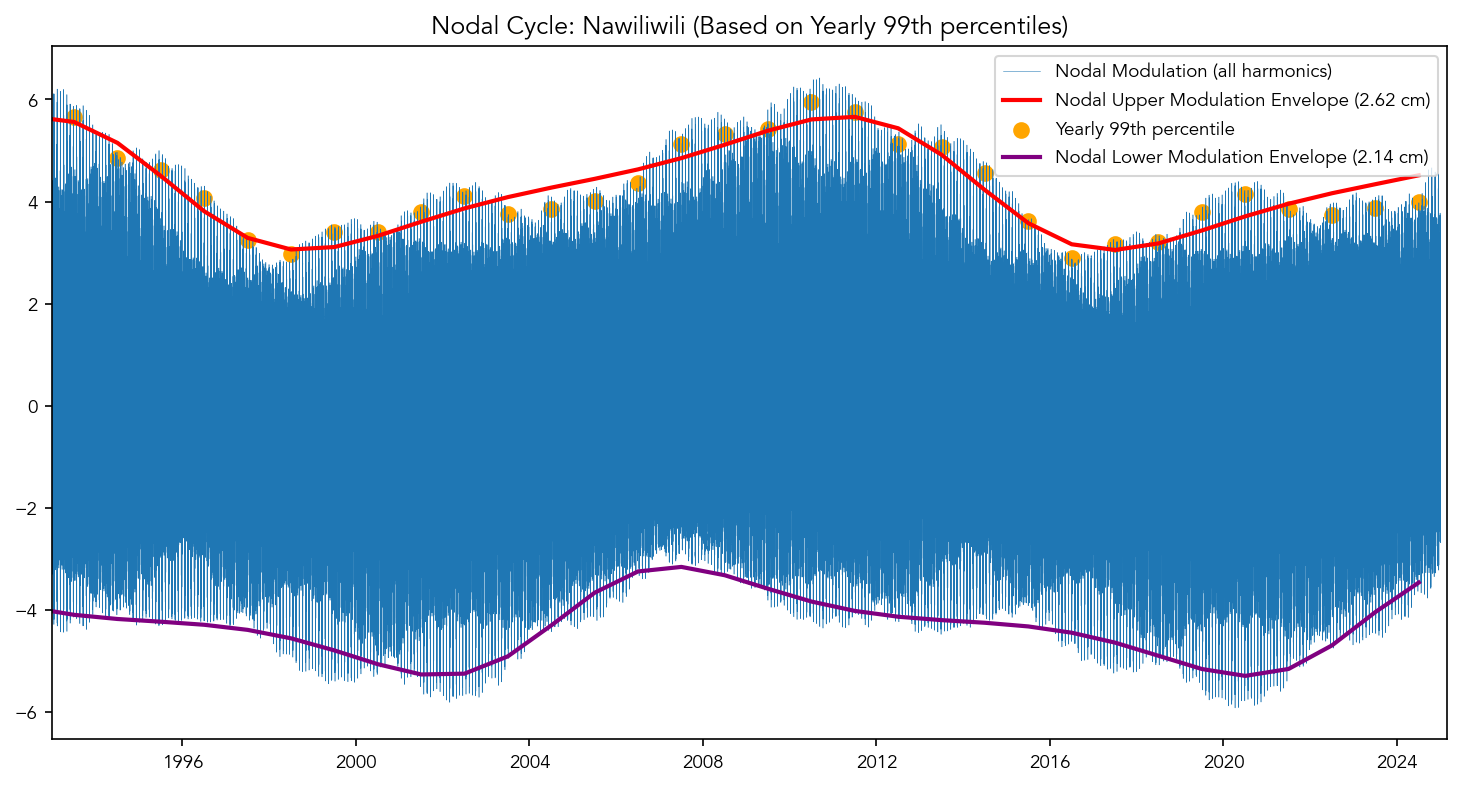

In [14]:
#plot the nodal signal and the envelope
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], 100*ntr_data['nodal'], label='Nodal Modulation (all harmonics)',linewidth=0.25)
plt.plot(ncyc_upper.index, 100*ncyc_upper, label='Nodal Upper Modulation Envelope (' + str(round(ncyc_mod_upper*100, 2)) + ' cm)', color='red', linewidth=2)
plt.scatter(ncyc_upper.index, 100*nodal_upper_envelope, label='Yearly 99th percentile', color='orange', linestyle='-', linewidth=2)
plt.plot(ncyc_lower.index, 100*ncyc_lower, label='Nodal Lower Modulation Envelope (' + str(round(ncyc_mod_lower*100, 2)) + ' cm)', color='purple', linewidth=2)
# plt.scatter(ncyc_lower.index, 100*nodal_lower_envelope, label='Yearly 1st percentile', color='cyan', linestyle='-', linewidth=2)

plt.title('Nodal Cycle: ' + station_name + ' (Based on Yearly 99th percentiles)')

plt.legend()
#set x-axis to 2017-2018
plt.xlim([np.datetime64('1993-01-01'), np.datetime64('2025-03-01')])

Text(0, 0.5, 'Predicted Water Level (cm)')

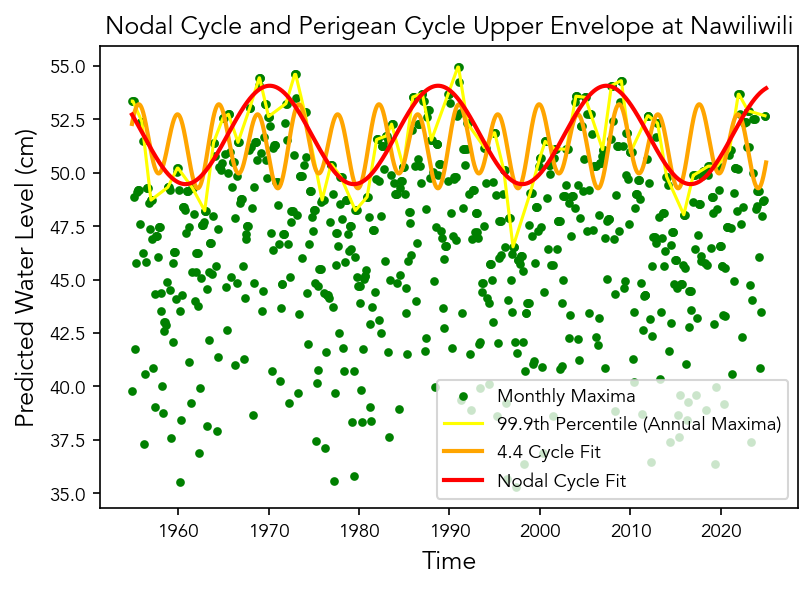

In [15]:
plt.scatter(monthly_max_real_date,100*monthly_max, label='Monthly Maxima', color='green',s=10)
plt.plot(yearly_max.index,100*yearly_max, label='99.9th Percentile (Annual Maxima)', color='yellow')
# plt.scatter(nodal_upper_envelope.index,0.1*nodal_upper_envelope, label='Nodal Cycle Upper Envelope Monthly', color='magenta',s=3)
# plt.scatter(nodal_upper_envelope1.index,0.1*nodal_upper_envelope1, label='Nodal Cycle Upper Envelope Monthly', color='yellow',s=3)


plt.plot(pcyc_upper_double.index, 100*(pcyc_upper_double), label='4.4 Cycle Fit', color='orange', lw=2)
plt.plot(nodal_upper.index, 100*(nodal_upper), label='Nodal Cycle Fit', color='red', lw=2)
# plt.plot(ncyc_upper.index, 0.1*(nodal_upper-nodal_upper.mean()+pcyc_upper_double), label='18.61y+4.425y+8.85y', color='blue', lw=2)
# add legend
plt.legend()

# add title
plt.title('Nodal Cycle and Perigean Cycle Upper Envelope at ' + station_name)
plt.xlabel('Time')
plt.ylabel('Predicted Water Level (cm)')
# interpolate the pyc_upper_double to the nodal cycle upper envelope

#set xlimits to just 2000-2022
# plt.xlim([np.datetime64('2010-01-01'), np.datetime64('2022-12-31')])

In [16]:
#extract top 10 tides
top_tides = ntr_data.nlargest(5, 'tide')
print('Top tides:')
print(top_tides[['time', 'tide']])

Top tides:
                      time      tide
315700 1990-12-02 14:00:00  0.549481
157660 1972-11-21 14:00:00  0.546034
123268 1968-12-19 14:00:00  0.544456
473740 2008-12-12 14:00:00  0.543071
315725 1990-12-03 15:00:00  0.542355


Text(0, 0.5, 'cm')

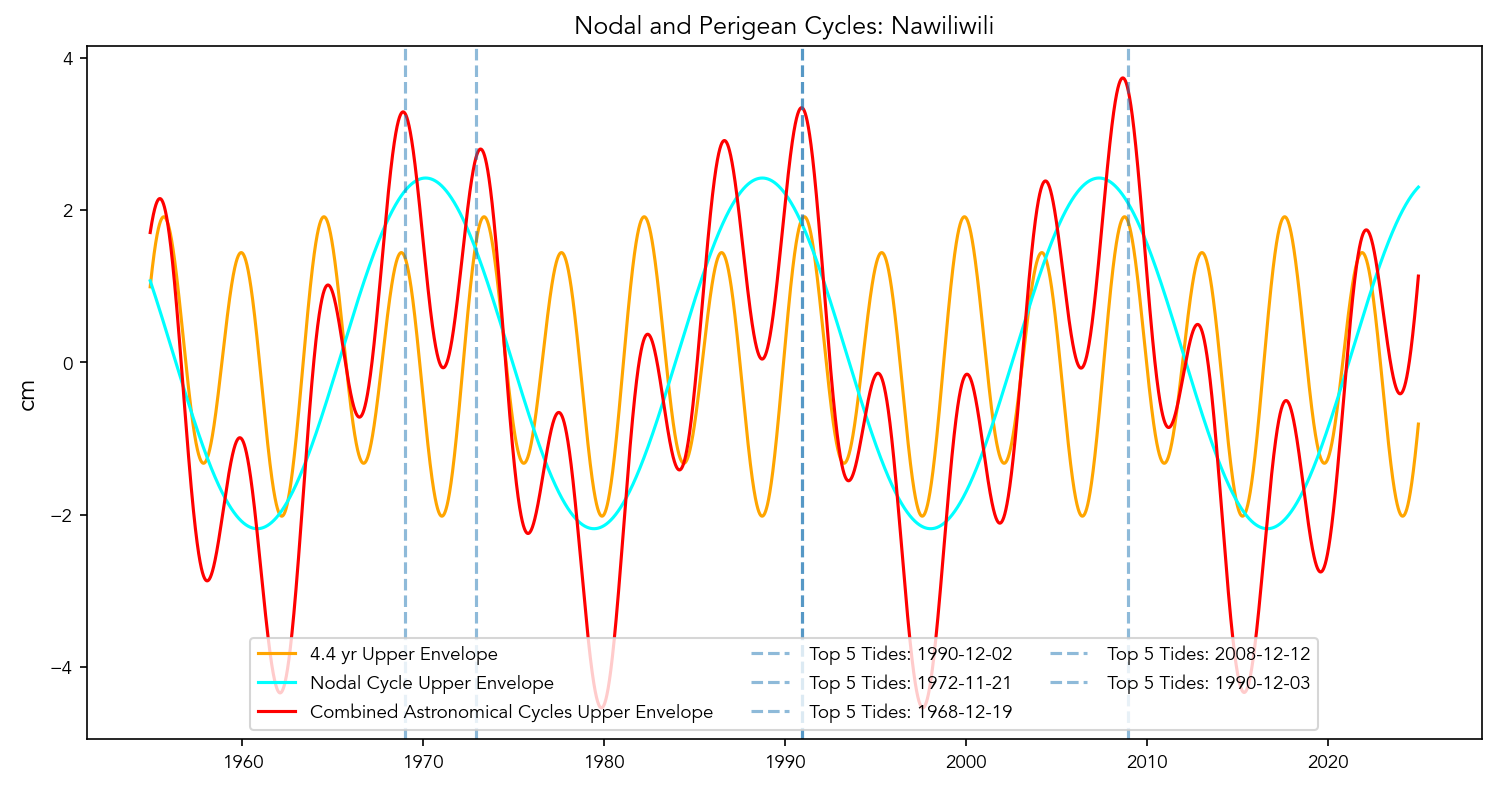

In [17]:
# plot the nodal and perigean cycles
plt.figure(figsize=(12, 6))
# plt.plot(ncyc_upper.index, 100*(ncyc_upper-ncyc_upper.mean()), label='Nodal Cycle Upper Envelope', color='blue')
plt.plot(pcyc_upper_double.index, 100*(pcyc_upper_double-pcyc_upper_double.mean()), label='4.4 yr Upper Envelope', color='orange')
# plt.plot(pcyc_upper_double.index, 100*(pcyc_upper_double-pcyc_upper_double.mean()+ncyc_upper-ncyc_upper.mean()), label='Perigean Cycle Upper Envelope', color='orange')
plt.plot(nodal_upper.index, 100*(nodal_upper-nodal_upper.mean()), label='Nodal Cycle Upper Envelope', color='cyan')
plt.plot(pcyc_upper_double.index, 100*(pcyc_upper_double-nodal_upper.mean()+nodal_upper-nodal_upper.mean()), label='Combined Astronomical Cycles Upper Envelope', color='red')
# plt.plot(ptime, 100*(ncyc_upper-ncyc_upper.mean()), label='Astronomical Stuff', color='cyan')

#mark the top 5 tides withv ertical lines
counter = 0
for i, row in top_tides.iterrows():
    counter += 1
    plt.axvline(row['time'], linestyle='--', alpha=0.5, label=f" Top 5 Tides: {row['time'].strftime('%Y-%m-%d')}")
plt.title('Nodal and Perigean Cycles: ' + station_name)

plt.legend(loc='lower center',ncol = 3)
plt.ylabel('cm')

# plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2024-01-01'))

In [18]:
perigean_cycle = pcyc_upper_double - pcyc_upper_double.mean()


In [19]:
# ntr_data['time'] = pd.to_datetime(ntr_data['time'])
# ntr_data = ntr_data.set_index('time')
# Reset the index to make 'time' a column, then create a subset dataframe
sea_level_data = ntr_data.reset_index()[['ntr', 'time']].copy()
# sea_level_data['time'] = ntr_data['time']
ntr_data_mags,ntr_trend_series,ntr_trend_rates = process_trend_with_nan(sea_level_data)
# sea_level_data
ntr_data['ntr_detrended'] = ntr_data['ntr'] - ntr_trend_series['ntr'] - ntr_data['seasonal_cycle']

In [20]:
ntr_data_mags


{'ntr': np.float64(-0.0008563426460660682)}

Text(0, 0.5, 'Non-tidal residuals (m)')

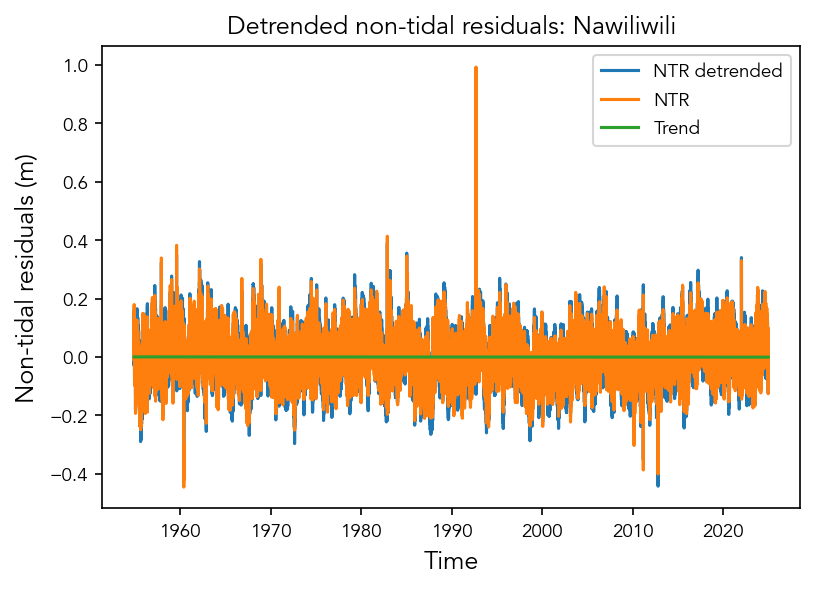

In [21]:
import matplotlib.pyplot as plt

# Ensure 'time' is a column in ntr_data
if 'time' not in ntr_data.columns:
	ntr_data = ntr_data.reset_index()

plt.plot(ntr_data['time'], ntr_data['ntr_detrended'], label='NTR detrended')
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
plt.plot(ntr_data['time'], ntr_trend_series['ntr'], label='Trend')
plt.legend()

# Add title
plt.title('Detrended non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

# Uncomment and adjust x-axis and y-axis limits as needed
# plt.xlim([np.datetime64('2017-10-01'), np.datetime64('2017-10-02')])
# plt.ylim([0, 200])

In [22]:
# Now start to filter for each frequency band we want

# make time_diffs in hours
time_diffs = np.diff(ntr_data['time']).astype('timedelta64[h]').astype(int)
widthSeasonal = 1/365.25/10; #1 cycle per decade



```{caution}
The timescales probably need some refinement. For example: mesoscale processes. Higher the latitude the longer the period!!
```
From Chen, S., and B. Qiu (2010), Mesoscale eddies northeast of the Hawaiian archipelago from satellite altimeter observations, J. Geophys. Res., 115, C03016, doi:10.1029/2009JC005698


"We define dominant periods of the mesoscale eddy activity by locating the periods at which the spectral peaks within the mesoscale range of 90–180 days. This definition is crude yet robust for the subregions with sharp spectral peaks like the 24°N–27°N, 160°W–155°W one (130 days) and the 18°N–21°N, 170°W–165°W one (90 days), but is also applicable to other subregions. In the lee of the island of Hawaii, 90 day oscillations dominate the mesoscale eddy activity. In the subregions between 24°N and 30°N, a 130 day peak often prevails, but in the 30°N–33°N band, a weak 180 day peak emerges. The pattern is that the higher the latitude, the longer the dominant period."

Also:
Firing, Y. L., and M. A. Merrifield (2004), Extreme sea level events at Hawaii: Influence of mesoscale eddies, Geophys. Res. Lett., 31, L24306, doi:10.1029/2004GL021539.

In [23]:
ntr_data

,time,ntr,ntr_noASA,sea_level,sea_level_detrended,trend,trendDiffEpoch,tide,nodal,ntr_withNodal,seasonal_cycle,dayofyear,ntr_detrended
0,1954-11-27 10:00:00,0.085718,0.105588,0.884,-0.005977,0.889977,0.063452,-0.091695,-0.003497,0.089215,0.019828,331,0.065461
1,1954-11-27 11:00:00,0.074311,0.094149,1.006,0.116022,0.889978,0.063452,0.041711,-0.006498,0.080809,0.019796,331,0.054086
2,1954-11-27 12:00:00,0.090504,0.110310,1.158,0.268022,0.889978,0.063452,0.177519,-0.008930,0.099433,0.019764,331,0.070310
3,1954-11-27 13:00:00,0.096688,0.116463,1.280,0.390022,0.889978,0.063452,0.293334,-0.010287,0.106975,0.019733,331,0.076526
4,1954-11-27 14:00:00,0.111380,0.131124,1.372,0.482022,0.889978,0.063451,0.370642,-0.010638,0.122018,0.019701,331,0.091250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
614434,2024-12-30 20:00:00,-0.125054,-0.127195,0.798,-0.221641,1.019641,-0.074303,-0.096587,-0.012759,-0.112295,-0.002183,365,-0.122443
614435,2024-12-30 21:00:00,-0.109395,-0.111559,0.783,-0.236642,1.019642,-0.074303,-0.127247,-0.001777,-0.107617,-0.002206,365,-0.106761
614436,2024-12-30 22:00:00,-0.068822,-0.071010,0.822,-0.197642,1.019642,-0.074303,-0.128820,0.009893,-0.078715,-0.002230,365,-0.066165
614437,2024-12-30 23:00:00,-0.027334,-0.029545,0.878,-0.141642,1.019642,-0.074303,-0.114308,0.020396,-0.047730,-0.002253,365,-0.024653


In [24]:
# Define timescales (in days)
annual = 365.25
biannual = 365.25*2
semiannual = 365.25/2
qtrannual = 365.25/4
daily = 7
weekly = 365.25/12
monthly = 3*365.25/12
decadal = 7*365.25
# interdecadal = 30*365.25


# make a dictionary of the timescales and the processes
timeframes = {'Decadal': 'e.g. PDO, 7-30+ yr', 
            #   'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-7 yr', 
              'Subannual': '3 months - 1 years', 
              'Monthly': '1 - 3 months',
              'Weekly': '1 -4 weeks', 
              'Storms & HF': '& other short-term variability',
              'Nodal Amp': '18.6 yr tidal modulation'}

# interpolate ncyc to the same time as ntr_data
ncyc_interp = ncyc_upper.reindex(ntr_data['time']).interpolate(method='linear')

In [25]:
ntr_data

,time,ntr,ntr_noASA,sea_level,sea_level_detrended,trend,trendDiffEpoch,tide,nodal,ntr_withNodal,seasonal_cycle,dayofyear,ntr_detrended
0,1954-11-27 10:00:00,0.085718,0.105588,0.884,-0.005977,0.889977,0.063452,-0.091695,-0.003497,0.089215,0.019828,331,0.065461
1,1954-11-27 11:00:00,0.074311,0.094149,1.006,0.116022,0.889978,0.063452,0.041711,-0.006498,0.080809,0.019796,331,0.054086
2,1954-11-27 12:00:00,0.090504,0.110310,1.158,0.268022,0.889978,0.063452,0.177519,-0.008930,0.099433,0.019764,331,0.070310
3,1954-11-27 13:00:00,0.096688,0.116463,1.280,0.390022,0.889978,0.063452,0.293334,-0.010287,0.106975,0.019733,331,0.076526
4,1954-11-27 14:00:00,0.111380,0.131124,1.372,0.482022,0.889978,0.063451,0.370642,-0.010638,0.122018,0.019701,331,0.091250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
614434,2024-12-30 20:00:00,-0.125054,-0.127195,0.798,-0.221641,1.019641,-0.074303,-0.096587,-0.012759,-0.112295,-0.002183,365,-0.122443
614435,2024-12-30 21:00:00,-0.109395,-0.111559,0.783,-0.236642,1.019642,-0.074303,-0.127247,-0.001777,-0.107617,-0.002206,365,-0.106761
614436,2024-12-30 22:00:00,-0.068822,-0.071010,0.822,-0.197642,1.019642,-0.074303,-0.128820,0.009893,-0.078715,-0.002230,365,-0.066165
614437,2024-12-30 23:00:00,-0.027334,-0.029545,0.878,-0.141642,1.019642,-0.074303,-0.114308,0.020396,-0.047730,-0.002253,365,-0.024653


In [26]:
def filter_ntr(ntr_data):
    # ntr_noAnnual, ntr_Annual = filter_known_frequency_components(ntr_data['ntr_detrended'], time_diffs,1/annual , width=widthSeasonal)
    # ntr_noSemiAnnual, ntr_SemiAnnual = filter_known_frequency_components(ntr_noAnnual, time_diffs, 1/semiannual, width=widthSeasonal)
    # ntr_noQtrAnnual, ntr_QtrAnnual = filter_known_frequency_components(ntr_noSemiAnnual, time_diffs, 1/qtrannual, width=widthSeasonal)
    # ntr_Seasonal = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual

    rec_length = (ntr_data['time'].max() - ntr_data['time'].min()).days
    
    # if rec_length < 35*365.25:
        #interdecadal
        # ntr_interdecadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr_detrended'], time_diffs, 1/interdecadal, order=3, padtype='even', padlen=3)
        #decadal
    ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr'], time_diffs, 1/decadal, order=3) 
    #     ntr_decadal = ntr_decadal + ntr_interdecadal
    # else:
    #     #interdecadal
    #     ntr_interdecadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr_detrended'], time_diffs, 1/interdecadal, order=3, padtype='even', padlen=3)
    #     #decadal
    #     ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/decadal, order=3)
    
    #interannual
    ntr_interannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/annual, order=3)

    # intraannual
    # this should be done in wavelets instead of a lowpass filter??

    ntr_subannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/monthly, order=5)

    ntr_monthly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/weekly, order=5)

    # Remove high frequencies (weekly to hourly)
    # ntr_weekly is timescales longer than 7 days but less than 1 month
    ntr_weekly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/daily, order=5)

    rank_tide = ntr_data['tide'].rank(method='first', ascending=False)

    # make dataframe of filtered data
    ntr_filtered = pd.DataFrame({'time': ntr_data['time'], 
                             'ntr': ntr_data['ntr'], 
                             'sea_level': ntr_data['sea_level'],
                             'sea_level_detrended': ntr_data['sea_level_detrended'],
                             'tide': ntr_data['tide'],
                             'Nodal Amp': ncyc_interp.values-ncyc_interp.mean(),
                             'Nodal Mod': ntr_data['nodal'],
                             'Perigean': perigean_cycle.values,
                             'Trend': ntr_data['trend'],
                            #  'Interdecadal': ntr_interdecadal, 
                             'Decadal': ntr_decadal, 
                             'Interannual': ntr_interannual, 
                             'Seasonal': ntr_data['seasonal_cycle'], 
                             'Subannual': ntr_subannual, 
                             'Monthly': ntr_monthly,
                             'Weekly': ntr_weekly, 
                             'Storms & HF': ntr_highFreq,
                             'Rank Tide': rank_tide} )
                        #    'NTR Trend': ntr_trend_series['ntr']
    # if rec_length < 35*365.25:
    #     ntr_filtered.pop('Interdecadal')

    component_names = list(ntr_filtered.columns) 
    component_names.remove('time')
    component_names.remove('ntr')
    component_names.remove('sea_level')
    component_names.remove('sea_level_detrended')
    component_names.remove('Nodal Amp')
    component_names.remove('Nodal Mod')
    component_names.remove('Rank Tide')

    # add trend back into ntr
    # ntr_filtered['ntr'] = ntr_filtered['ntr'] + ntr_filtered['NTR Trend']
    
    return ntr_filtered, component_names


In [27]:
ntr_filtered,component_names = filter_ntr(ntr_data)

# get std of each component
ntr_component_stds = ntr_filtered.std()

# remove time from ntr)component_stds
ntr_component_stds = ntr_component_stds.drop('time')
ntr_component_stds = ntr_component_stds.drop('Rank Tide')

Filled 1 % of data with noise (std = 0.0640).


In [28]:
# save ntr_component_stds to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station_id:03d}_component_stds.csv')
ntr_component_stds.to_csv(savepath)


In [29]:
ntr_filtered

,time,ntr,sea_level,sea_level_detrended,tide,Nodal Amp,Nodal Mod,Perigean,Trend,Decadal,Interannual,Seasonal,Subannual,Monthly,Weekly,Storms & HF,Rank Tide
0,1954-11-27 10:00:00,0.085718,0.884,-0.005977,-0.091695,NaN,-0.003497,0.009936,0.889977,0.006730,0.026789,0.019828,0.045646,0.002670,0.018303,-0.014420,406345.0
1,1954-11-27 11:00:00,0.074311,1.006,0.116022,0.041711,NaN,-0.006498,0.009938,0.889978,0.006728,0.026776,0.019796,0.045627,0.002627,0.018936,-0.026383,222778.0
2,1954-11-27 12:00:00,0.090504,1.158,0.268022,0.177519,NaN,-0.008930,0.009941,0.889978,0.006726,0.026764,0.019764,0.045608,0.002584,0.019564,-0.010741,109432.0
3,1954-11-27 13:00:00,0.096688,1.280,0.390022,0.293334,NaN,-0.010287,0.009944,0.889978,0.006724,0.026751,0.019733,0.045589,0.002539,0.020187,-0.005103,42390.0
4,1954-11-27 14:00:00,0.111380,1.372,0.482022,0.370642,NaN,-0.010638,0.009946,0.889978,0.006722,0.026738,0.019701,0.045570,0.002495,0.020805,0.009051,14809.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614434,2024-12-30 20:00:00,-0.125054,0.798,-0.221641,-0.096587,0.00214,-0.012759,-0.008104,1.019641,0.002041,0.072311,-0.002183,-0.029167,-0.023323,-0.042716,-0.104200,414130.0
614435,2024-12-30 21:00:00,-0.109395,0.783,-0.236642,-0.127247,0.00214,-0.001777,-0.008101,1.019642,0.002041,0.072311,-0.002206,-0.029167,-0.023323,-0.042717,-0.088540,460486.0
614436,2024-12-30 22:00:00,-0.068822,0.822,-0.197642,-0.128820,0.00214,0.009893,-0.008098,1.019642,0.002041,0.072311,-0.002230,-0.029167,-0.023323,-0.042717,-0.047967,462707.0
614437,2024-12-30 23:00:00,-0.027334,0.878,-0.141642,-0.114308,0.00214,0.020396,-0.008095,1.019642,0.002041,0.072311,-0.002253,-0.029167,-0.023323,-0.042717,-0.006479,441343.0


Note that to define the upper envelope we used monthly maxima. So there should be NO correlation in the weekly/storms.

Next, a sanity check to make sure that everything adds up to the right sum.

In [30]:
component_names

['tide',
 'Perigean',
 'Trend',
 'Decadal',
 'Interannual',
 'Seasonal',
 'Subannual',
 'Monthly',
 'Weekly',
 'Storms & HF']

In [31]:
component_names
#remove Trend from component names
toRemove = ['Trend', 'Perigean', 'Seasonal','Rank Tide']
for remove in toRemove:
    if remove in component_names:
        component_names.remove(remove)

In [32]:
component_names

['tide',
 'Decadal',
 'Interannual',
 'Subannual',
 'Monthly',
 'Weekly',
 'Storms & HF']

Text(0.5, 1.0, 'Sum of components vs Sea Level')

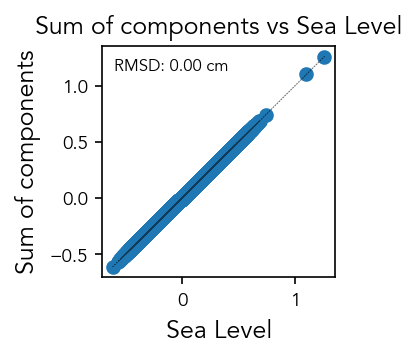

In [33]:
#plot ntr, then plot summed components
plt.figure(figsize=(2, 2))

# sum all components in components_names programmatically
ntr_sum = ntr_filtered[component_names].sum(axis=1)


#make a dotted 1:1 line
plt.plot(ntr_filtered['sea_level_detrended'], ntr_filtered['sea_level_detrended'], 'k:', label='1:1 line',linewidth=0.5,alpha=0.5)
plt.scatter(ntr_filtered['sea_level_detrended'], ntr_sum)

plt.xlabel('Sea Level')
plt.ylabel('Sum of components')

# add RMSD to plot
rmsd = np.sqrt(np.mean((ntr_filtered['sea_level_detrended'] - ntr_sum)**2))
plt.text(0.05, 0.95, f'RMSD: {rmsd:.2f} cm', ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.title('Sum of components vs Sea Level')


In [34]:
#export data
# ntr_filtered.to_csv('data/ntr_filtered_059b.csv', index=False)
ntr_filtered.keys()

Index(['time', 'ntr', 'sea_level', 'sea_level_detrended', 'tide', 'Nodal Amp',
       'Nodal Mod', 'Perigean', 'Trend', 'Decadal', 'Interannual', 'Seasonal',
       'Subannual', 'Monthly', 'Weekly', 'Storms & HF', 'Rank Tide'],
      dtype='object')

Text(0.5, 1.0, 'Correlation between each component')

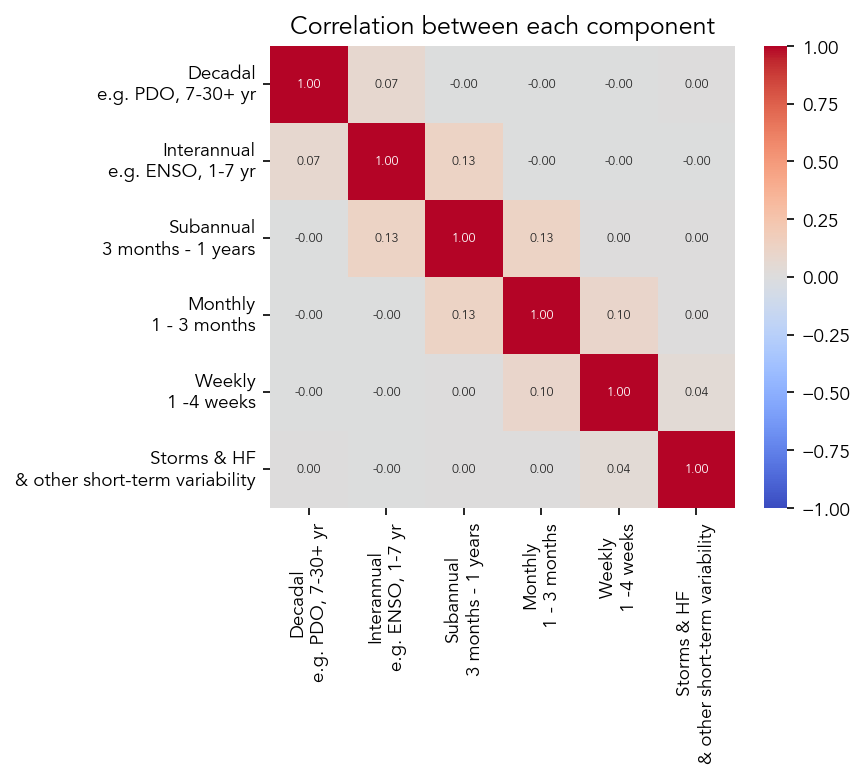

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

#make a heatmap plot of correlation between each component
ntr_corr = ntr_filtered.drop(['time','sea_level','sea_level_detrended','tide','ntr','Nodal Amp','Nodal Mod','Trend','Seasonal','Perigean','Rank Tide'], axis=1).corr()

# add description to each component in ntr correlation matrix
ntr_corr.columns = [col + '\n' + timeframes[col] for col in ntr_corr.columns]
ntr_corr.index = [col + '\n' + timeframes[col] for col in ntr_corr.index]
#exclude time,sea_level, and tide from the correlation matrix

#plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(ntr_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation between each component')



Note there is correlation between some of these timeseries, likely due to the filtering process employed in this notebook. 

In [36]:
# get the cumulative sum of the components
ntr_component_names = component_names.copy()
ntr_component_names.remove('tide')
# move trend and Seasonal to the beginning of the list
# ntr_component_names.remove('Seasonal')
ntr_component_names.insert(0, 'Seasonal')
# ntr_component_names.remove('Rank Tide')
# ntr_component_names.remove('NTR Trend')
# ntr_component_names.insert(0, 'NTR Trend')
ntr_cumsum = ntr_filtered[ntr_component_names].cumsum(axis=1)
ntr_cumsum_stds = ntr_cumsum.std()
ntr_cumsum_stds


# make a plot of ntr_filtered and ntr_cumsum
# fig, ax = plt.subplots(figsize=(12, 6))
# ntr_filtered.plot(x='time', y=['ntr'], ax=ax, color=['black'], linewidth=1)
# ntr_filtered_sums.plot(x='time', y=['Nodal'] +['> 20 years'], ax=ax, color='yellow',linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years'], ax=ax, linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years', '10-20 year', '1-10 year', 'Seasonal', '1 month - 1 year', '1 week - 1 month', '< 1 week'], ax=ax, linewidth=1, linestyle='--')

Seasonal       0.035547
Decadal        0.041180
Interannual    0.052152
Subannual      0.061542
Monthly        0.066241
Weekly         0.069048
Storms & HF    0.073163
dtype: float64

In [37]:
ntr_filtered.keys()

Index(['time', 'ntr', 'sea_level', 'sea_level_detrended', 'tide', 'Nodal Amp',
       'Nodal Mod', 'Perigean', 'Trend', 'Decadal', 'Interannual', 'Seasonal',
       'Subannual', 'Monthly', 'Weekly', 'Storms & HF', 'Rank Tide'],
      dtype='object')

In [38]:
ntr_filtered

,time,ntr,sea_level,sea_level_detrended,tide,Nodal Amp,Nodal Mod,Perigean,Trend,Decadal,Interannual,Seasonal,Subannual,Monthly,Weekly,Storms & HF,Rank Tide
0,1954-11-27 10:00:00,0.085718,0.884,-0.005977,-0.091695,NaN,-0.003497,0.009936,0.889977,0.006730,0.026789,0.019828,0.045646,0.002670,0.018303,-0.014420,406345.0
1,1954-11-27 11:00:00,0.074311,1.006,0.116022,0.041711,NaN,-0.006498,0.009938,0.889978,0.006728,0.026776,0.019796,0.045627,0.002627,0.018936,-0.026383,222778.0
2,1954-11-27 12:00:00,0.090504,1.158,0.268022,0.177519,NaN,-0.008930,0.009941,0.889978,0.006726,0.026764,0.019764,0.045608,0.002584,0.019564,-0.010741,109432.0
3,1954-11-27 13:00:00,0.096688,1.280,0.390022,0.293334,NaN,-0.010287,0.009944,0.889978,0.006724,0.026751,0.019733,0.045589,0.002539,0.020187,-0.005103,42390.0
4,1954-11-27 14:00:00,0.111380,1.372,0.482022,0.370642,NaN,-0.010638,0.009946,0.889978,0.006722,0.026738,0.019701,0.045570,0.002495,0.020805,0.009051,14809.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614434,2024-12-30 20:00:00,-0.125054,0.798,-0.221641,-0.096587,0.00214,-0.012759,-0.008104,1.019641,0.002041,0.072311,-0.002183,-0.029167,-0.023323,-0.042716,-0.104200,414130.0
614435,2024-12-30 21:00:00,-0.109395,0.783,-0.236642,-0.127247,0.00214,-0.001777,-0.008101,1.019642,0.002041,0.072311,-0.002206,-0.029167,-0.023323,-0.042717,-0.088540,460486.0
614436,2024-12-30 22:00:00,-0.068822,0.822,-0.197642,-0.128820,0.00214,0.009893,-0.008098,1.019642,0.002041,0.072311,-0.002230,-0.029167,-0.023323,-0.042717,-0.047967,462707.0
614437,2024-12-30 23:00:00,-0.027334,0.878,-0.141642,-0.114308,0.00214,0.020396,-0.008095,1.019642,0.002041,0.072311,-0.002253,-0.029167,-0.023323,-0.042717,-0.006479,441343.0


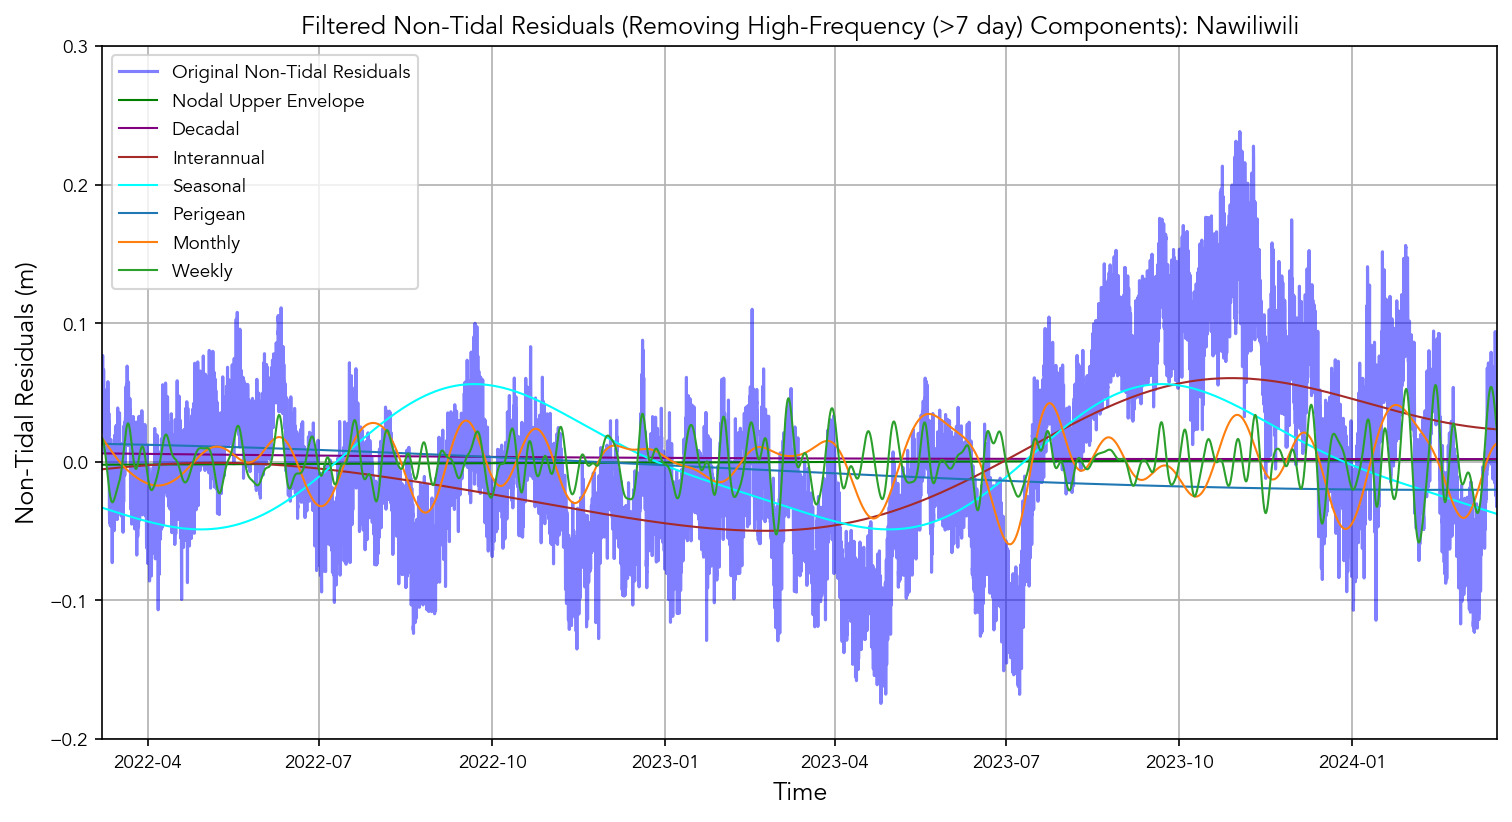

In [39]:
# Plot original vs. filtered signal
plt.figure(figsize=(12, 6))
plt.plot(ntr_filtered['time'], ntr_filtered['ntr'], label='Original Non-Tidal Residuals', color ="blue",alpha=0.5)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='$NTR - NTR_{hf}$', color='orange', linewidth=2)

# ntr_summed = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual + ntr_subAnnual + ntr_multiyear + ntr_decadal + ntr_lowFreq + ntr_monthly
# ntr_summed = ntr_filtered['Nodal']+ ntr_filtered['> 20 years'] + ntr_filtered['10-20 year'] + ntr_filtered['1-10 year'] + ntr_filtered['Seasonal'] + ntr_filtered['1 month - 1 year'] + ntr_filtered['1 week - 1 month'] + ntr_filtered['< 1 week']

# plt.plot(ntr_filtered['time'], ntr_summed, label='Sum of Filtered Components', color='red', linewidth=1)

plt.plot(ntr_filtered['time'], ntr_filtered['Nodal Amp'], label='Nodal Upper Envelope', color='green', linewidth=1)
# # plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='> 20 years', color='orange', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Decadal'], label='Decadal', color='purple', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Interannual'], label='Interannual', color='brown', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Seasonal'], label='Seasonal', color='cyan', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['Subannual'], label='Subannual', color='black', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Perigean'], label='Perigean', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Monthly'], label='Monthly', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Weekly'], label='Weekly', linewidth=1)

# plt.plot(ntr_filtered['time'], ntr_filtered['1 week - 2 month'], label='1 week - 2 month', color='pink', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['< 1 week'], label='< 1 week', color='grey', linewidth=1)
# plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR with Nodal Cycle')



plt.xlabel('Time')
plt.ylabel('Non-Tidal Residuals (m)')
plt.title('Filtered Non-Tidal Residuals (Removing High-Frequency (>7 day) Components): ' + station_name)
plt.legend()
plt.grid()

# change xlim to zoom in
plt.xlim(pd.Timestamp('2022-03-08'), pd.Timestamp('2024-3-18'))
plt.ylim(-0.2,0.3)
plt.show()

In [40]:
ntr_filtered
#resample to monthly
ntr_filtered_monthly = ntr_filtered.resample('ME', on='time').mean()

Text(0.5, 1.0, 'Interannual NTR and PMM')

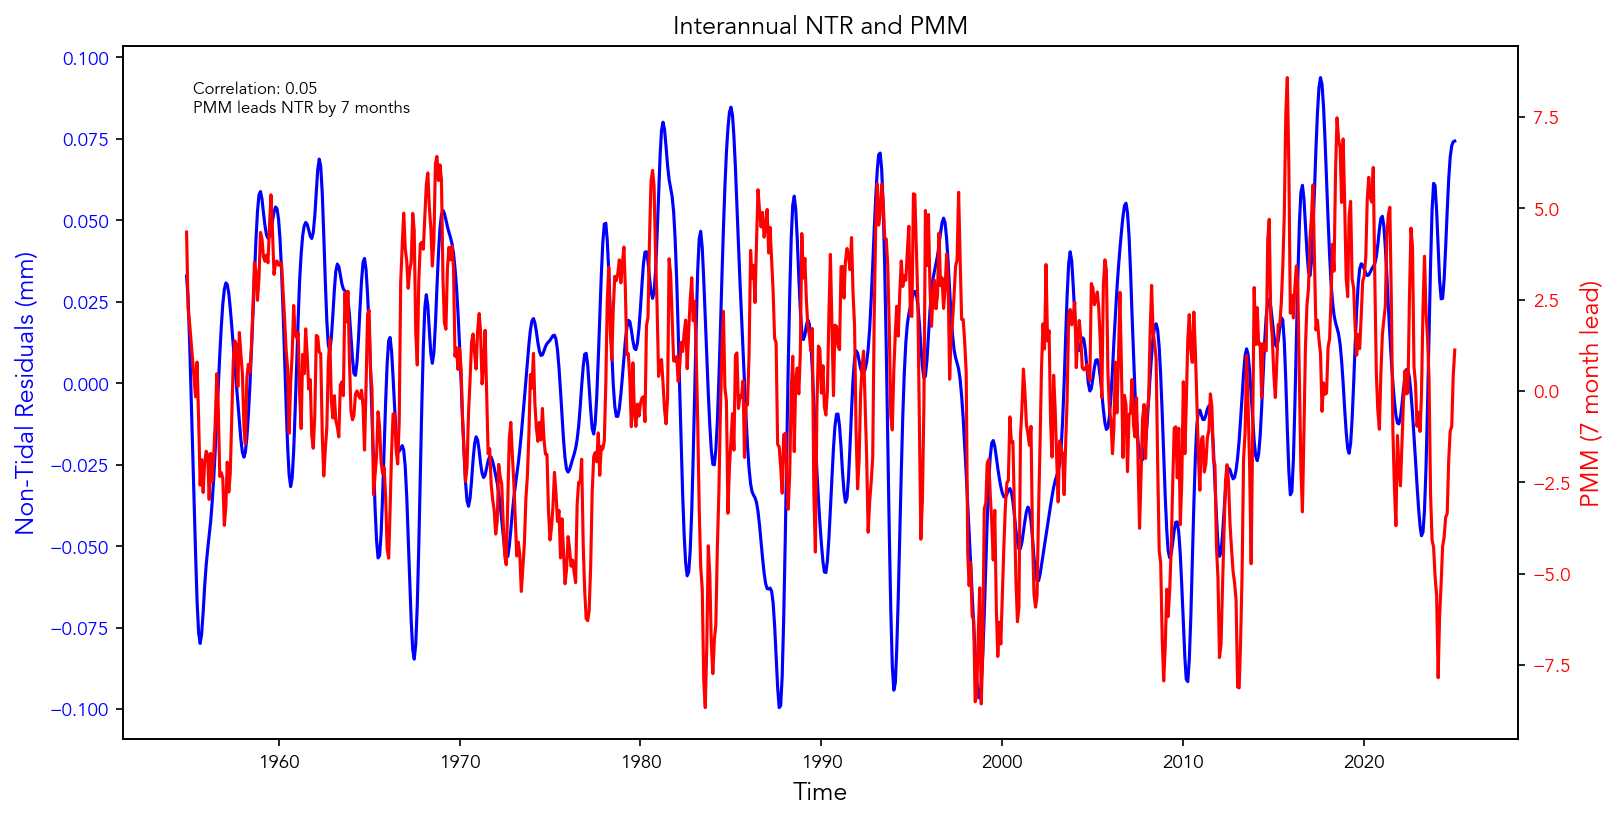

In [41]:
# Is the interannual component correlated with ENSO? Let's use the ONI index
# load ONI data

CI_dir = Path(data_dir / 'climate_indices')
climateIndex = ['AO','BEST','ONI','PDO','PMM','PNA','TNA']

CIcorr = np.zeros((len(climateIndex), 30))

# Arrays to store peak correlation and lag for each climate index
CIcorr_max_peaks = np.zeros(len(climateIndex))
CIcorr_max_lag = np.zeros(len(climateIndex))

for indCI in range(len(climateIndex)):
    CI = pd.read_csv(CI_dir / (climateIndex[indCI] + '.csv'), parse_dates=['time'])
    # ntr_CI = pd.merge_asof(ntr_filtered_monthly.sort_index(), CI.sort_index(), left_index=True, right_index=True, direction='nearest')
    CI['time'] = pd.to_datetime(CI['time'])

    # Perform the merge
    ntr_CI = pd.merge_asof(ntr_filtered_monthly, CI, left_index=True, right_on='time', direction='nearest')
    # Define the number of lags
    lag = 30
    corr = np.zeros(lag)

    if climateIndex[indCI] == 'PDO' or climateIndex[indCI] == 'PMM': #<--- IS THIS CORRECT?
        # For PDO and PMM, we need to add the decadal component to the interannual component
        ntr_CI['signal'] = ntr_CI['Interannual'] + ntr_CI['Decadal']
    else:
        # For other climate indices, we just use the interannual component
        ntr_CI['signal'] = ntr_CI['Interannual']


    # Calculate lagged correlation
    for i in range(1, lag + 1):
        corr[i - 1] = np.corrcoef(ntr_CI[climateIndex[indCI]][:-i], ntr_CI['signal'][i:])[0, 1]
    CIcorr[indCI,:] = corr
    # get max correlation and lag
    CIcorr_max_peaks[indCI] = np.max(abs(CIcorr[indCI,:]))
    CIcorr_max_lag[indCI] = np.argmax(abs(CIcorr[indCI,:]))

# Use the max correlation to determine the winning Climate Index
climateIndex_bestcorr = climateIndex[np.argmax(abs(CIcorr_max_peaks))]
climateIndex_bestlag = CIcorr_max_lag[np.argmax(abs(CIcorr_max_peaks))]

# now adjust the climateIndex by the lag and plot together with the ntr

CI = pd.read_csv(CI_dir / (climateIndex_bestcorr + '.csv'), parse_dates=['time'])
#adjust the time by the lag
CI['time'] = pd.to_datetime(CI['time'])
CI['time'] = CI['time'] + pd.DateOffset(months=CIcorr_max_lag[np.argmax(abs(CIcorr_max_peaks))])
# Perform the merge
ntr_CI = pd.merge_asof(ntr_filtered_monthly, CI, left_index=True, right_on='time', direction='nearest')
# rename the columns

#plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(ntr_CI['time'], ntr_CI['Interannual']+ntr_CI['Decadal'], label='Interannual NTR', color='blue')
# ax1.plot(ntr_CI['time'], ntr_CI['Decadal'], label='Decadal NTR', color='blue')

# plt.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label=climateIndex_bestcorr, color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Non-Tidal Residuals (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for ONI
ax2 = ax1.twinx()
ax2.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label=climateIndex_bestcorr, color='red')
ylabel = climateIndex_bestcorr  + f' ({climateIndex_bestlag:.0f} month lead)'
ax2.set_ylabel(ylabel, color='red')
ax2.tick_params(axis='y', labelcolor='red')

corr = ntr_CI['Interannual'].corr(ntr_CI[climateIndex_bestcorr])
if corr < 0:
    ax2.invert_yaxis()  # Flip the axis

# add text for correlation
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}\n{climateIndex_bestcorr} leads NTR by {climateIndex_bestlag:.0f} months', ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.title('Interannual NTR and ' + climateIndex_bestcorr)

In [42]:
CIcorr_max_peaks
# ['AO','BEST','ONI','PDO','PMM','PNA','TNA']

array([0.0969797 , 0.16510532, 0.2000971 , 0.1742928 , 0.2634832 ,
       0.09697973, 0.21655073])

In [43]:
ntr_CI

,ntr,sea_level,sea_level_detrended,tide,Nodal Amp,Nodal Mod,Perigean,Trend,Decadal,Interannual,Seasonal,Subannual,Monthly,Weekly,Storms & HF,Rank Tide,time,PMM
time,,,,,,,,,,,,,,,,,,
1954-11-30,0.113733,1.033453,0.143467,0.029734,NaN,0.000064,0.010045,0.889986,0.006641,0.026238,0.018491,0.044729,0.000287,0.029633,0.006205,287921.895349,1954-12-01,4.35
1954-12-31,0.046038,0.942081,0.052007,0.005969,NaN,0.000119,0.011075,0.890074,0.005778,0.020290,0.006441,0.022911,-0.000459,-0.002231,-0.000251,304383.254032,1955-01-01,2.25
1955-01-31,-0.026067,0.853563,-0.036668,-0.010601,NaN,-0.000070,0.012811,0.890231,0.004267,0.007955,-0.011099,-0.038010,0.000044,-0.000852,0.000529,317898.655914,1955-02-01,1.84
1955-02-28,-0.049465,0.816391,-0.073989,-0.024524,NaN,-0.000004,0.014301,0.890380,0.002881,-0.005463,-0.024265,-0.042241,-0.006291,0.002452,-0.000803,330797.952381,1955-03-01,1.37
1955-03-31,0.013790,0.868054,-0.022476,-0.036266,NaN,-0.000142,0.015610,0.890530,0.001554,-0.020073,-0.036730,0.020895,0.009888,0.000889,0.000637,343346.227151,1955-04-01,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.120858,1.179097,0.160146,0.039288,0.00214,0.000074,-0.015927,1.018951,0.002039,0.060647,0.039986,0.055580,0.002282,-0.000258,0.000569,270817.072581,2024-09-01,-1.89
2024-09-30,0.116021,1.190367,0.171261,0.055240,0.00214,-0.000066,-0.014455,1.019105,0.002040,0.067373,0.054901,0.039003,0.008535,-0.000230,-0.000700,249854.925000,2024-10-01,-1.10
2024-10-31,0.038677,1.107224,0.087965,0.049288,0.00214,-0.000126,-0.012804,1.019260,0.002040,0.070854,0.048447,-0.015992,-0.016980,-0.001494,0.000248,255481.114247,2024-11-01,-0.97


In [44]:
ntr_component_stds
# save to csv

ntr                     0.06395
sea_level              0.189239
sea_level_detrended    0.185499
tide                   0.174117
Nodal Amp              0.008281
Nodal Mod              0.019317
Perigean               0.012213
Trend                  0.037431
Decadal                0.020799
Interannual            0.030512
Seasonal               0.035547
Subannual              0.029119
Monthly                0.021124
Weekly                 0.017533
Storms & HF            0.023509
dtype: object

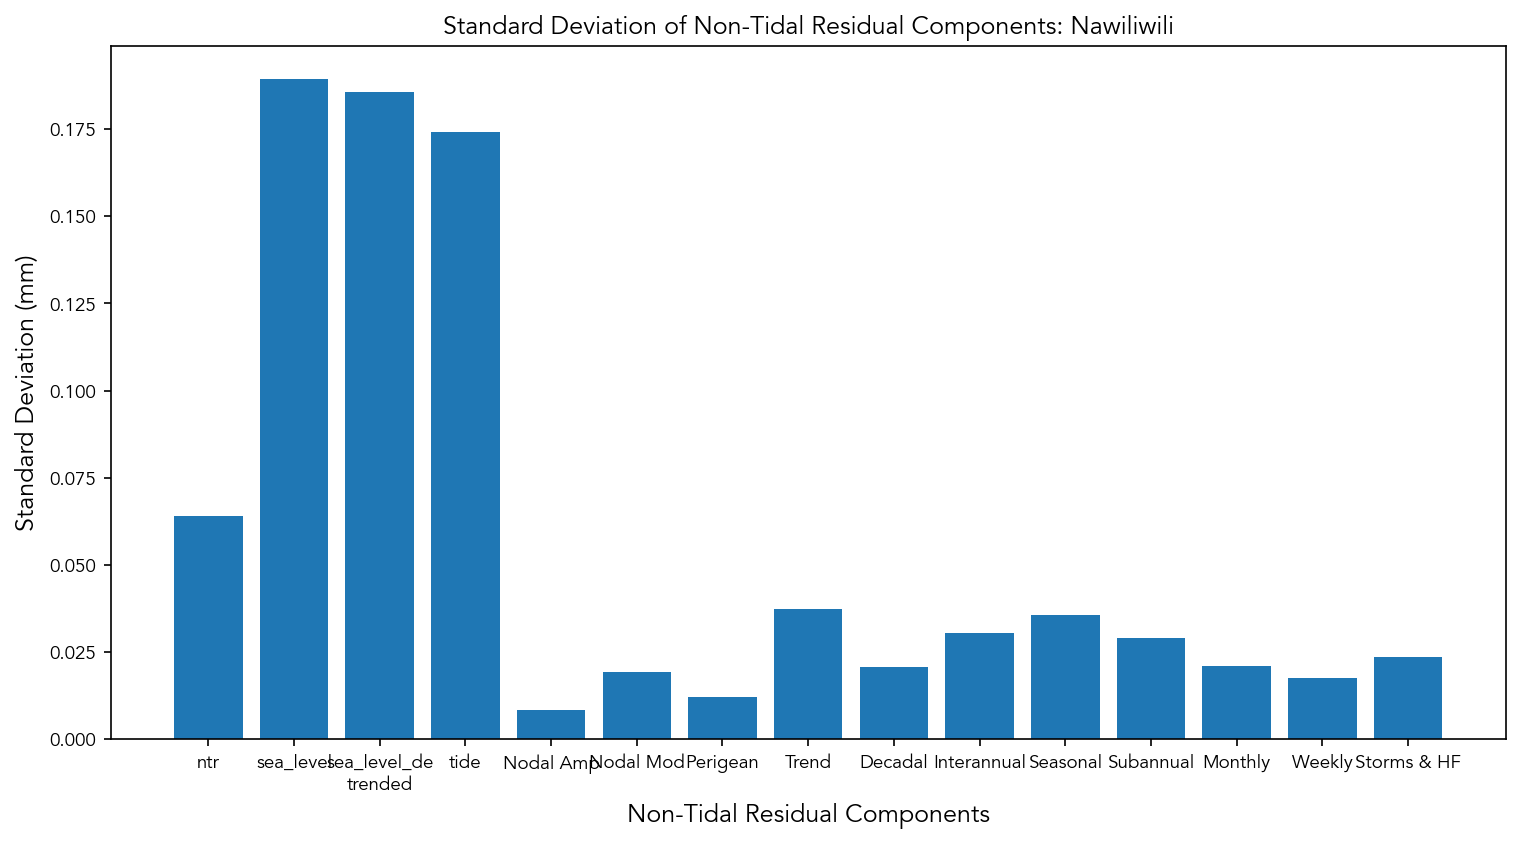

In [45]:
#make a bar plot of the std of each component
import textwrap

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(ntr_component_stds.index, ntr_component_stds)
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=12)) for label in ntr_component_stds.index]
plt.xticks(range(len(ntr_component_stds.index)), wrapped_labels)
# plt.xticks(rotation=45)
ax.set_xlabel('Non-Tidal Residual Components')
ax.set_ylabel('Standard Deviation (mm)')
ax.set_title('Standard Deviation of Non-Tidal Residual Components: ' + station_name)


plt.show()

In [46]:
# does the total variance of the components equal the variance of the ntr?

# get the variance of each component
components = ['Decadal','Interannual','Subannual','Monthly','Weekly','Storms & HF']
ntr_component_vars = ntr_filtered[components].var()

# get the sum of the variances
ntr_component_vars_sum = ntr_component_vars.sum()
# get the variance of the ntr
ntr_var =ntr_filtered['ntr'].var()

print('Sum of variances of components:', ntr_component_vars_sum)
print('Variance of ntr:', ntr_var)


print('"Wave Height" contributions:', 0.4* np.sqrt(ntr_component_vars_sum))
print('"Wave Height" ntr:', 0.4 * np.sqrt(ntr_var))

ntr_component_vars

# save ntr_component_vars to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station_id:03d}_component_vars2.csv')
ntr_component_vars.to_csv(savepath)


Sum of variances of components: 0.003517837605218713
Variance of ntr: 0.004089617862071597
"Wave Height" contributions: 0.023724544607536605
"Wave Height" ntr: 0.025580048043963008


In [47]:
ntr_data

,time,ntr,ntr_noASA,sea_level,sea_level_detrended,trend,trendDiffEpoch,tide,nodal,ntr_withNodal,seasonal_cycle,dayofyear,ntr_detrended
0,1954-11-27 10:00:00,0.085718,0.105588,0.884,-0.005977,0.889977,0.063452,-0.091695,-0.003497,0.089215,0.019828,331,0.065461
1,1954-11-27 11:00:00,0.074311,0.094149,1.006,0.116022,0.889978,0.063452,0.041711,-0.006498,0.080809,0.019796,331,0.054086
2,1954-11-27 12:00:00,0.090504,0.110310,1.158,0.268022,0.889978,0.063452,0.177519,-0.008930,0.099433,0.019764,331,0.070310
3,1954-11-27 13:00:00,0.096688,0.116463,1.280,0.390022,0.889978,0.063452,0.293334,-0.010287,0.106975,0.019733,331,0.076526
4,1954-11-27 14:00:00,0.111380,0.131124,1.372,0.482022,0.889978,0.063451,0.370642,-0.010638,0.122018,0.019701,331,0.091250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
614434,2024-12-30 20:00:00,-0.125054,-0.127195,0.798,-0.221641,1.019641,-0.074303,-0.096587,-0.012759,-0.112295,-0.002183,365,-0.122443
614435,2024-12-30 21:00:00,-0.109395,-0.111559,0.783,-0.236642,1.019642,-0.074303,-0.127247,-0.001777,-0.107617,-0.002206,365,-0.106761
614436,2024-12-30 22:00:00,-0.068822,-0.071010,0.822,-0.197642,1.019642,-0.074303,-0.128820,0.009893,-0.078715,-0.002230,365,-0.066165
614437,2024-12-30 23:00:00,-0.027334,-0.029545,0.878,-0.141642,1.019642,-0.074303,-0.114308,0.020396,-0.047730,-0.002253,365,-0.024653


In [48]:
# "wave height" of each component
ntr_component_waveheight = 100*ntr_cumsum_stds *4
ntr_component_waveheight

# add long-term trend to the "wave height" stack, get trend value from Jan 1993 to Jan 2023
# get trend rate from ntr_data['NTR Trend'] 
SLR = ntr_filtered[['Trend','time']].copy()
# set time as index
SLR['time'] = pd.to_datetime(SLR['time'])
SLR.set_index('time', inplace=True)
# get the slope of the trend - it is linear so just a-b over time
SLR_m_day = (SLR['Trend'].iloc[-1] - SLR['Trend'].iloc[0]) / (SLR.index[-1] - SLR.index[0]).days 

SLR_cm30yr = 100*SLR_m_day*365.25 # convert to cm/yr

ntr_component_waveheight = pd.concat([pd.Series(SLR_cm30yr, index=['Long-Term Trend']), ntr_component_waveheight+SLR_cm30yr], axis=0)


# # add long-term trend to the "wave height" stack, get trend value from Jan 1993 to Jan 2023
# # get trend rate from ntr_data['trend'] 
# SLR = ntr_data[['trend','time']].copy()
# # set time as index
# SLR['time'] = pd.to_datetime(SLR['time'])
# SLR.set_index('time', inplace=True)
# # get the slope of the trend - it is linear so just a-b over time
# SLR_mm_day = (SLR['trend'].iloc[-1] - SLR['trend'].iloc[0]) / (SLR.index[-1] - SLR.index[0]).days 

# SLR_cm30yr = SLR_mm_day*365.25/10 # convert to cm/yr

# ntr_component_waveheight = pd.concat([pd.Series(SLR_cm30yr, index=['Long-Term Trend']), ntr_component_waveheight+SLR_cm30yr], axis=0)

ntr_component_waveheight

Long-Term Trend     0.184993
Seasonal           14.403890
Decadal            16.657056
Interannual        21.045952
Subannual          24.801750
Monthly            26.681516
Weekly             27.804056
Storms & HF        29.450229
dtype: float64

## Plot components
Make a bar plot of average contributions to water levels.

/var/folders/qp/nn19rcjs5bdcdvxmff5bd3pr0000gn/T/ipykernel_77982/3885298619.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



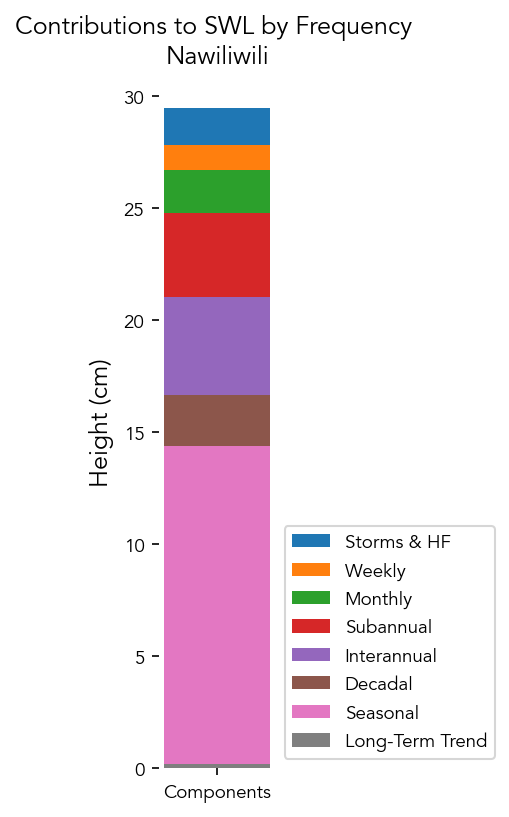

In [49]:
# Create figure
fig, ax = plt.subplots(figsize=(1, 6))
# ntr_component_vars_cumsum = ntr_component_vars.cumsum()/ntr_component_vars_sum * ntr_var #normalize to the variance of the ntr (not filtered)
# Plot stacked bars
bottom = 0
for i in range(len(ntr_component_waveheight.index)-1, -1, -1):
    ax.bar('Components', ntr_component_waveheight[i], bottom=0, label=ntr_component_waveheight.index[i].replace('\n', ' '))

# ax.bar('Total NTR', np.std(ntr_filled), color='white', edgecolor='black', linewidth=1)

# Labels and title
ax.set_ylabel('Height (cm)')
ax.set_title('Contributions to SWL by Frequency \n' + station_name)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# no box
for spine in ax.spines.values():
    spine.set_visible(False)

figName = 'NTR_components_stds' + station_name
glue('NTR_components_stds',fig,display=False)

# save the wave height to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station_id:03d}_component_waveheight.csv')
ntr_component_waveheight.to_csv(savepath)


In [50]:
# combine all Path(data_dir, f'ntr_data/ntr_{station:03d}_component_waveheight.csv') into one plot
# get all the csv files in ntr_data
import glob
# get all the csv files in ntr_data
ntr_data_dir = Path(data_dir, 'ntr_data')
ntr_data_files = glob.glob(os.path.join(ntr_data_dir, '*component_waveheight.csv'))

# Read and tag each file
df_list = []
for file in ntr_data_files:
    df = pd.read_csv(file, index_col=None)

    station = int(Path(file).stem.split('_')[1])  # extract station number
    df.columns = ['station',station]
    df_list.append(df)

# Combine into one DataFrame

ntr_combined = pd.concat(
    {df.columns[1]: df.set_index('station').iloc[:, 0] for df in df_list},
    axis=1
)

ntr_combined = ntr_combined[sorted(ntr_combined.columns)]

ntr_combined
# # subtract first row from all rows
# ntr_combined = ntr_combined.sub(ntr_combined.iloc[0], axis=1)
# # delete the first row
# ntr_combined = ntr_combined.drop(ntr_combined.index[0])
#divide all by the last row
ntr_combined_norm = ntr_combined.div(ntr_combined.iloc[-1], axis=1)
ntr_combined_norm

,1611400,1612340,1612480,1615680,1617433,1617760,1619910
station,,,,,,,
Long-Term Trend,0.006282,0.003822,0.003284,0.005091,0.004754,0.000961,0.007884
Seasonal,0.489093,0.409227,0.369521,0.395172,0.349781,0.231316,0.318030
Decadal,0.565600,0.540329,0.550959,0.559034,0.577169,0.541607,0.458952
Interannual,0.714628,0.717756,0.746357,0.732327,0.729578,0.611506,0.589862
Subannual,0.842158,0.817192,0.841550,0.817926,0.819562,0.647189,0.750925
Monthly,0.905987,0.860946,0.894270,0.858912,0.901699,0.677913,0.819712
Weekly,0.944103,0.891233,0.926470,0.892683,0.926135,0.694415,0.903564
Storms & HF,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


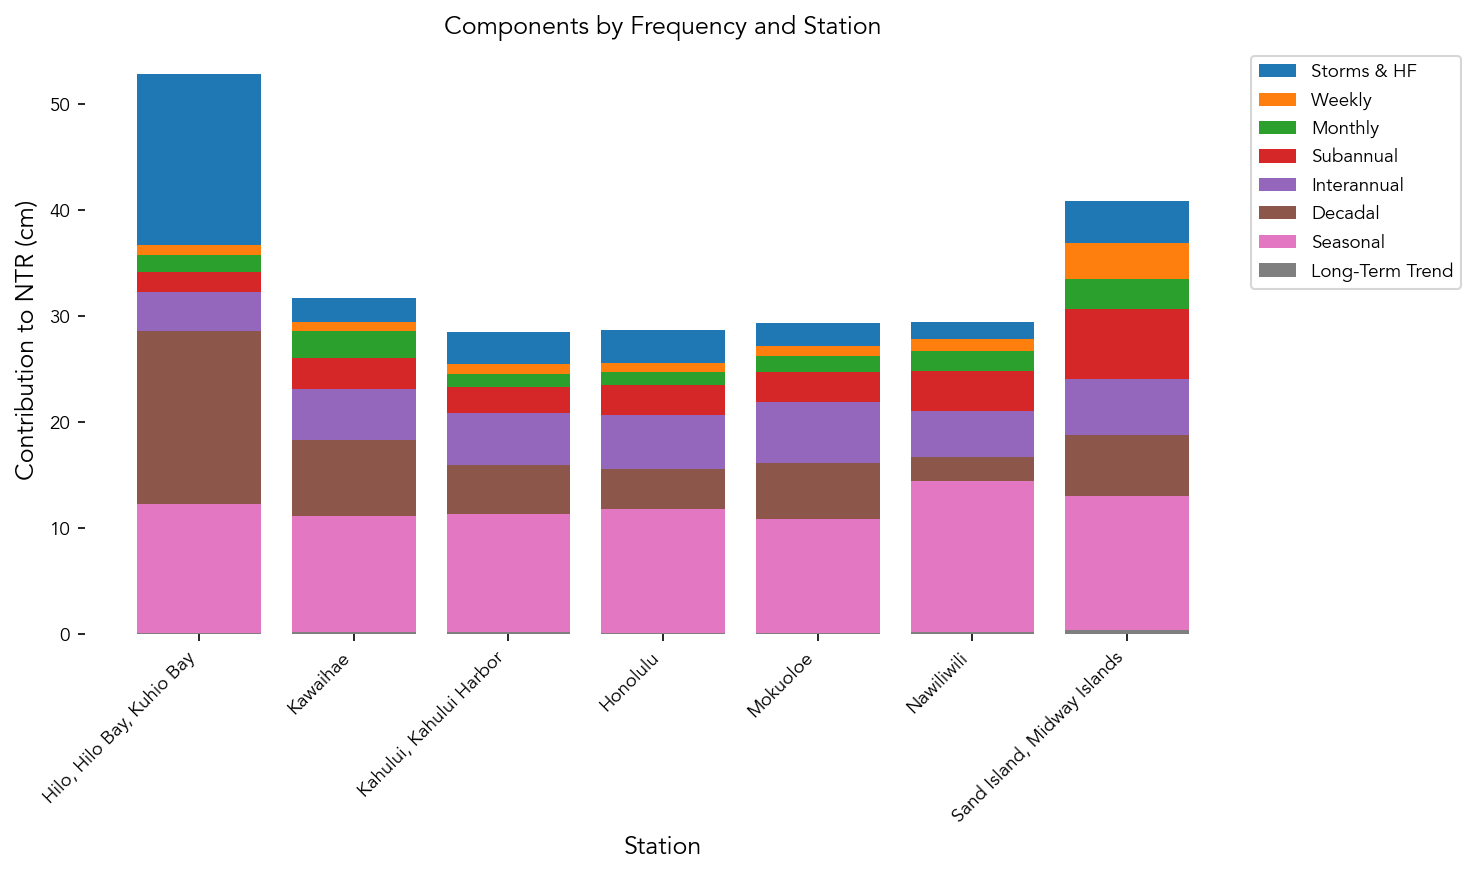

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Set up figure
fig, ax = plt.subplots(figsize=(10, 6))  # adjust width based on number of stations

# Station names and component labels
stations = ntr_combined.columns

# remove 552
# stations = [station for station in stations if station != 552]
stations = [station for station in stations if station != 548]
stations = [station for station in stations if station != 14]
stations = [station for station in stations if station != 547]



# only include stations in ds
stations = [station for station in stations if station in ds.station_id.values]

# # remove French Frigate, Kaumalapau, and Barbers Point
# stations = [station for station in stations if station not in [552, 548, 14, 547]]

# get latitude of stations
latitudes = ds.lat.sel(station_id=stations).values
# sort by latitude

sorted_indices = np.argsort(latitudes)
# sort stations by latitude
stations = np.array(stations)[sorted_indices]

# Get the components
ntr_combined_norm = ntr_combined_norm[stations]
ntr_combined = ntr_combined[stations]
components = ntr_combined.index
x = np.arange(len(stations))  # one x-position per station

# Set color palette
colors = plt.cm.tab20(np.linspace(0, 1, len(components)))

# Plot each component
bottom = np.zeros(len(stations))
for i, component in reversed(list(enumerate(components))):
    heights = ntr_combined.loc[component].values
    ax.bar(x, heights, bottom=0, label=component.replace('\n', ' '))
    bottom += heights

#names of stations instead of numbers, make a dictionary
station_names = ds.station_name.sel(station_id=stations).values

# Customize axes
ax.set_ylabel("Contribution to NTR (cm)")
ax.set_xlabel("Station")
ax.set_title("Components by Frequency and Station")
ax.set_xticks(x)
ax.set_xticklabels(station_names, rotation=45, horizontalalignment='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Remove box
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()



It's important to note that in the plot above, we're looking at the $4\sigma$, which is akin to 'significant wave height.' Nor do we consider each $\sigma$ independently in this plot, but instead we compute the standard deviation of the combined signals, as we work our way up to higher and higher frequencies. For example, the purple line above shows the contributions of any cycles that occur on timescales longer than 1 year. Each individual componenent has its own standard deviation but none are truly indepedent signals (due to the filtering mechanism here) and therefore the variances cannot be directly added together to represent the total variances of the whole signal. (See the correlation plot above.)

In [52]:
# get dates of extreme events
# station_name_1st = station_name.split(',')[0]
top10tableName = 'SL_top_10_table_' + station_name + '.csv'


extremes_csv = Path(output_dir, top10tableName)
extremes = pd.read_csv(extremes_csv)

In [53]:
extremes

,Rank,Highest,Highest Date,Highest ONI Mode,Lowest,Lowest Date,Lowest ONI Mode,Zone,ONI max,ONI min
0,1,0.451,2023-10-30 15:00,El Nino,-0.871,2011-03-12 00:00,La Nina,GMT,1.92,-0.93
1,2,0.425,2022-01-15 12:00,La Nina,-0.821,2010-02-28 07:00,El Nino,GMT,-0.97,0.84
2,3,0.415,2024-08-20 02:00,Neutral,-0.813,2010-03-05 22:00,El Nino,GMT,-0.21,0.84
3,4,0.409,2024-11-16 14:00,Neutral,-0.788,2000-01-21 07:00,La Nina,GMT,-0.52,-1.41
4,5,0.392,2020-12-15 15:00,La Nina,-0.784,2002-02-27 07:00,Neutral,GMT,-1.19,0.09
5,6,0.390,2017-07-23 02:00,Neutral,-0.780,1993-11-15 07:00,Neutral,GMT,-0.11,0.04
6,7,0.384,2021-12-05 15:00,Neutral,-0.780,1994-02-06 03:00,Neutral,GMT,-0.98,0.07
7,8,0.378,2023-08-30 01:00,Neutral,-0.777,1993-12-14 07:00,Neutral,GMT,1.56,0.06
8,9,0.374,2024-08-31 00:00,Neutral,-0.776,1994-02-03 00:00,Neutral,GMT,-0.21,0.07
9,10,0.373,2016-06-05 02:00,Neutral,-0.775,1993-11-12 05:00,Neutral,GMT,-0.07,0.04


In [54]:
extremes_highest = extremes['Highest Date'].values
extremes_lowest = extremes['Lowest Date'].values

extremes_highest = pd.to_datetime(extremes_highest)
extremes_lowest = pd.to_datetime(extremes_lowest)

extremes_highest

DatetimeIndex(['2023-10-30 15:00:00', '2022-01-15 12:00:00',
               '2024-08-20 02:00:00', '2024-11-16 14:00:00',
               '2020-12-15 15:00:00', '2017-07-23 02:00:00',
               '2021-12-05 15:00:00', '2023-08-30 01:00:00',
               '2024-08-31 00:00:00', '2016-06-05 02:00:00'],
              dtype='datetime64[ns]', freq=None)

In [55]:
# extract these dates from the ntr filtered data
ntr_filtered_extremes_high = ntr_filtered[ntr_filtered['time'].isin(extremes_highest)].copy()
ntr_filtered_extremes_low = ntr_filtered[ntr_filtered['time'].isin(extremes_lowest)].copy()

# get tide data for these dates from ntr_data
tide_data = ntr_data['tide']
ntr_data_extremes_high = ntr_data[ntr_data['time'].isin(extremes_highest)].copy()
ntr_data_extremes_low = ntr_data[ntr_data['time'].isin(extremes_lowest)].copy()

# add tide and sea level data to ntr_filtered_extremes_high
ntr_filtered_extremes_high.loc[:, 'tide'] = ntr_data_extremes_high['tide'].values
ntr_filtered_extremes_high.loc[:, 'sea_level'] = ntr_data_extremes_high['sea_level'].values
ntr_filtered_extremes_low.loc[:, 'tide'] = ntr_data_extremes_low['tide'].values
ntr_filtered_extremes_low.loc[:, 'sea_level'] = ntr_data_extremes_low['sea_level'].values


# arrange columns
# if rec_length < 35*365.25:
column_order = ['time', 'ntr', 'sea_level', 'sea_level_detrended', 'tide','Rank Tide', 'Trend','Nodal Amp','Nodal Mod', 'Perigean', 'Decadal', 'Interannual', 'Seasonal', 'Subannual','Monthly','Weekly', 'Storms & HF']
# else:
    # column_order = ['time', 'ntr', 'sea_level', 'tide', 'Nodal Amp','Nodal Mod','Interdecadal', 'Decadal', 'Interannual', 'Seasonal','Intraannual', 'Weekly', 'Storms & HF']
ntr_filtered_extremes_high = ntr_filtered_extremes_high[column_order]
ntr_filtered_extremes_low = ntr_filtered_extremes_low[column_order]
ntr_filtered_extremes_high

#export data
savename_high = 'ntr_filtered_extremes_high_' + f'_{station:03d}'+ '.csv'
savename_low = 'ntr_filtered_extremes_low_' + f'_{station:03d}'+ '.csv'
ntr_path = data_dir / 'ntr_data'
ntr_filtered_extremes_high.to_csv(ntr_path / savename_high, index=False)
ntr_filtered_extremes_low.to_csv(ntr_path / savename_low, index=False)


In [56]:
ntr_filtered_extremes_high[['ntr', 'sea_level', 'time','Trend','Rank Tide']].sort_values(by='sea_level', ascending=False)


,ntr,sea_level,time,Trend,Rank Tide
604181,0.220217,1.706,2023-10-30 15:00:00,1.017478,1511.0
588506,0.329812,1.680,2022-01-15 12:00:00,1.014170,25246.0
611248,0.170516,1.670,2024-08-20 02:00:00,1.018969,945.0
613372,0.117893,1.664,2024-11-16 14:00:00,1.019417,50.0
579005,0.129573,1.647,2020-12-15 15:00:00,1.012165,260.0
549208,0.153887,1.645,2017-07-23 02:00:00,1.005877,780.0
587525,0.088291,1.639,2021-12-05 15:00:00,1.013963,16.0
602703,0.105828,1.633,2023-08-30 01:00:00,1.017166,198.0
611510,0.198757,1.629,2024-08-31 00:00:00,1.019024,6692.0
539296,0.196565,1.628,2016-06-05 02:00:00,1.003785,4681.0


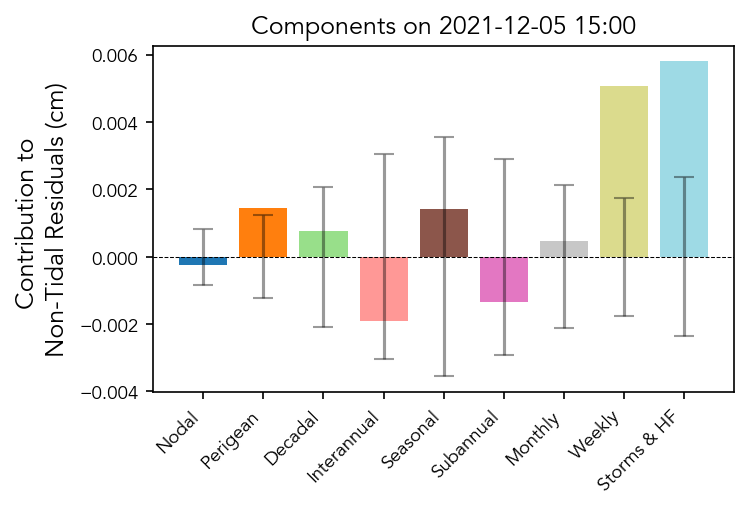

In [57]:
# make separate plot for comparison of event size vs climatology

idx = 3

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date = ntr_filtered_extremes_high['time'].values[idx]
date_str = pd.to_datetime(event_date).strftime('%Y-%m-%d %H:%M')
data_on_date = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]


# Extract the components
components = column_order[6:]
# remove 'Nodal Mod' from components
components.remove('Nodal Mod')
components.remove('Trend')
# components.remove('NTR Trend')
component_values = data_on_date[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component
y_stds = 0.1*ntr_component_stds[components].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']


fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# assign 1 color to each component. There are XX components, so we need XX colors
colors = plt.cm.tab20(np.linspace(0, 1, len(components)))


### --- TOP LEFT PLOT: Bar Chart --- ###
bar_width = 0.2
ax.bar(x_positions, 0.1*component_values, alpha=1, color=colors)
ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='Standard Deviation')

ax.set_xticks(x_positions)

# replace 'Nodal Amp' with 'Nodal' in the x-ticks
components = [comp.replace('Nodal Amp', 'Nodal') for comp in components]
ax.set_xticklabels(components, rotation=45, ha='right')

# Title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nNon-Tidal Residuals (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

In [58]:
idx = 2
event_date = ntr_filtered_extremes_high['time'].values[idx]
data_on_event = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]
date_str = pd.to_datetime(event_date).strftime('%B %d, %Y')


In [59]:
def adjust_axFormat(ax):
    ax.tick_params(axis='y', labelsize=7,which='both',direction='in')
    ax.tick_params(axis='x', labelsize=7,which='both',direction='in')
    ax.yaxis.label.set_size(8)
    ax.xaxis.label.set_size(8)

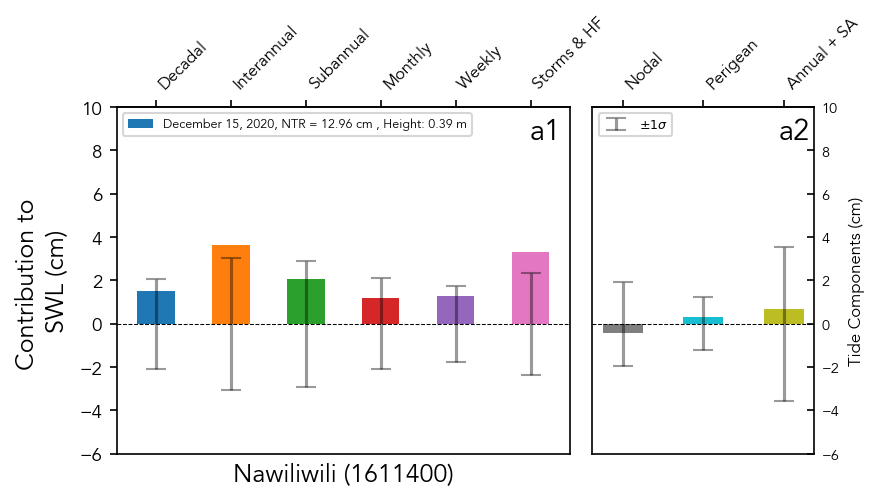

In [60]:
# make timeseries figure
import matplotlib.pyplot as plt
# add mdates for x-axis formatting
import matplotlib.dates as mdates

componentsNTR = ['Decadal', 'Interannual', 'Subannual', 'Monthly', 'Weekly', 'Storms & HF']
componentsTide = ['Nodal Mod', 'Perigean', 'Seasonal']

fig, ax = plt.subplots(1, 1, figsize=(6, 3))


component_values = data_on_event[componentsNTR].values.flatten()
# component_values2 = data_on_event2[componentsNTR].values.flatten()
hatches = '//////'

x_positions = np.arange(len(componentsNTR))  # Positions for each component
y_stds = 100*ntr_component_stds[componentsNTR].values.flatten()

x_positionsTide = np.arange(len(componentsTide)) + 0.4  # Positions for each tide component
y_stdsTide = 100*ntr_component_stds[componentsTide].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']

# assign 1 color to each component. There are XX components, so we need XX colors
# component_order = ['Nodal', 'Decadal', 'Interannual', 'Seasonal', 'Subannual', 'Monthly','Weekly', 'Storms & HF']
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[:5] + tab10_colors[6:7]
colorsTide = tab10_colors[7:10]  # Use the last 3 colors for tide components
component_colors = {comp: colors[i % 6] for i, comp in enumerate(componentsNTR)}
component_colorsTide = {comp: colorsTide[i % 3] for i, comp in enumerate(componentsTide)}
#switch the last two colors in component_colorsTide
component_colorsTide['Seasonal'], component_colorsTide['Perigean'] = component_colorsTide['Perigean'], component_colorsTide['Seasonal']


### Bar Chart --- ###
bar_width = 0.5

ax.bar(
    x_positions,
    100*component_values,
    alpha=1,
    color=[component_colors[c] for c in componentsNTR],
    width=bar_width,
    label=date_str + ', NTR = ' + f'{100 * data_on_event["ntr"].values[0]:.2f} cm , Height: ' + f"{data_on_event['sea_level'].values[0] - mhhw:.2f} m"
)

ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5)
ax.legend(fontsize=6, frameon=True, loc='upper left')
ax.set_xticks(x_positions)


# Move x-tick labels to the top
ax.set_xticklabels([])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(x_positions)
ax_top.set_xticklabels(componentsNTR, rotation=45, ha='left', fontsize=8)

#remove bottom x-ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Title and labels
# ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nSWL (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_ylim([-6, 10])

box = ax.get_position()
#make it skinnier
ax.set_position([box.x0, box.y0, box.width * 0.65, box.height])  # Shrink width to 50%
box_skinny = ax.get_position()
# add another axis on the right for the tide components

ax2 = fig.add_axes([box_skinny.x0 + box_skinny.width+0.025, box.y0, box.width * 0.35-0.025, box.height])  # Create a new Axes on the right side
# Plot tide components

ax2.bar(x_positionsTide, 100*data_on_event[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width)
# ax2.bar(x_positionsTide+0.2, 0.1*data_on_event2[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width, hatch=hatches)
ax2.set_ylabel('Tide Components (cm)')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
#remove bottom x-ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.set_ylim([-6,10])
ax2.errorbar(x_positionsTide, np.zeros_like(x_positionsTide), yerr=y_stdsTide, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='$\pm 1\sigma$')
ax.set_xticks(x_positions)

ax2.legend(fontsize=6, frameon=True, loc='upper left')


# Move x-tick labels to the top
ax2.set_xticklabels([])
ax2_top = ax2.secondary_xaxis('top')
ax2_top.set_xticks(x_positionsTide)
componentsTide = [comp.replace('Nodal Mod', 'Nodal') for comp in componentsTide]
componentsTide = [comp.replace('Seasonal', 'Annual + SA') for comp in componentsTide]
ax2_top.set_xticklabels(componentsTide, rotation=45, ha='left', fontsize=8)

#put ylabel on the right side
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

adjust_axFormat(ax2)

ax2.text(0.98, 0.97, 'a2', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')
    
ax.text(0.98, 0.97, 'a1', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')
        
# add station info on the bottom xlabel
ax.set_xlabel(station_name + ' (' + str(station_id) + ')')

# save the file to desktop as a png
figName = 'NTR_components_' + station_name + '_' + date_str
glue(figName,fig,display=False)

savepath = Path(output_dir, figName + '.png')
fig.savefig(savepath, dpi=300, bbox_inches='tight')


In [61]:
# Verify if 'ntr' matches the sum of components (excluding 'Nodal Mod' and 'Seasonal')
ntr_actual = data_on_event['ntr'].values[0]
ntr_sum = data_on_event[componentsNTR].sum(axis=1)

if np.isclose(ntr_actual, ntr_sum):
    print("NTR is equal to the sum of the components.")
else:
    print("NTR is NOT equal to the sum of the components.")
    print(f"NTR: {ntr_actual}")
    print(f"Sum of components: {ntr_sum}")

NTR is equal to the sum of the components.


In [62]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd
# import numpy as np

idx = 3

# sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
dates_to_plot = ntr_filtered_extremes_high['time'].values[idx]
# date_str = pd.to_datetime(dates_to_plot).strftime('%Y-%m-%d %H:%M')
# data_on_date = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == dates_to_plot]

# # Extract the components
# components = column_order[4:]
# # remove 'Nodal Mod' from components
# components.remove('Nodal Amp')
# component_values = data_on_date[components].values.flatten()

# # set tide and trend relative to MHHW
# component_values[components.index('tide')] -= 0.1*mhhw + 0.1*msl
# # # do the same for the trend
# component_values[components.index('Trend')] -= 0.1*mhhw + 0.1*msl

# # remove tide and trend

# component_values = np.delete(component_values, [components.index('tide'), components.index('Trend')])
# components.remove('tide')
# components.remove('Trend')

# x_positions = np.arange(len(components))  # Positions for each component

# fig, axes = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# # assign 1 color to each component. There are XX components, so we need XX colors
# colors = plt.cm.tab20(np.linspace(0, 1, len(components)))




# Filter data to ±10 days around `dates_to_plot`
plusTime = pd.Timedelta('2d')
timespan = pd.date_range(start=dates_to_plot - plusTime, end=dates_to_plot + plusTime, freq='h')

# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)


In [63]:
# We need to treat the tide component differently here to get a better comparison
# get the daily high tides
tide_data = ntr_data['tide']
tide_data.index = ntr_data['time']
tide_max_daily = tide_data.resample('D').max()

tide_max_daily_std = tide_max_daily.std()

tide_min_daily = tide_data.resample('D').min()
tide_min_daily_std = tide_min_daily.std()

In [64]:
ntr_filtered_extremes_low

,time,ntr,sea_level,sea_level_detrended,tide,Rank Tide,Trend,Nodal Amp,Nodal Mod,Perigean,Decadal,Interannual,Seasonal,Subannual,Monthly,Weekly,Storms & HF
341515,1993-11-12 05:00:00,-0.181387,0.480,-0.482047,-0.300661,602182.0,0.962047,0.011098,0.018599,-0.007749,0.007423,-0.092836,0.031436,-0.040891,-0.035396,-0.003367,-0.016318
341589,1993-11-15 07:00:00,-0.170179,0.475,-0.487063,-0.316884,606435.0,0.962063,0.011063,0.000662,-0.007608,0.007465,-0.094226,0.029094,-0.044468,-0.035831,0.006784,-0.009903
342285,1993-12-14 07:00:00,-0.143539,0.478,-0.484210,-0.340671,610627.0,0.962210,0.010738,-0.003817,-0.006225,0.007866,-0.102339,0.007816,-0.034544,0.024651,-0.015713,-0.023460
343502,1994-02-03 00:00:00,-0.216226,0.479,-0.483467,-0.267240,589929.0,0.962467,0.010168,0.010149,-0.003588,0.008564,-0.095439,-0.018884,-0.006336,-0.031871,-0.053829,-0.037316
343577,1994-02-06 03:00:00,-0.212337,0.475,-0.487483,-0.275145,593374.0,0.962483,0.010133,-0.001657,-0.003418,0.008607,-0.094256,-0.020241,-0.005631,-0.032187,-0.054042,-0.034829
395781,2000-01-21 07:00:00,-0.119832,0.467,-0.506499,-0.386667,614003.0,0.973499,-0.010701,-0.000122,0.018764,-0.047706,0.012691,-0.012924,-0.014282,-0.066135,0.020608,-0.025009
414213,2002-02-27 07:00:00,-0.147419,0.471,-0.506389,-0.358970,612483.0,0.977389,-0.005240,0.019717,-0.013190,-0.033873,-0.020644,-0.029376,-0.001576,-0.036848,-0.017347,-0.037130
484365,2010-02-28 07:00:00,-0.235843,0.434,-0.558193,-0.322350,607590.0,0.992193,0.012341,-0.019671,-0.004106,-0.037625,-0.054697,-0.029773,-0.075983,-0.034351,0.009712,-0.042899
484500,2010-03-05 22:00:00,-0.284800,0.442,-0.550222,-0.265421,589102.0,0.992222,0.012375,0.024057,-0.004424,-0.037708,-0.054718,-0.032250,-0.080924,-0.018739,-0.022665,-0.070046
493406,2011-03-12 00:00:00,-0.386723,0.384,-0.610101,-0.223378,564998.0,0.994101,0.013435,-0.000804,-0.012340,-0.037775,0.027673,-0.034801,-0.025287,-0.003515,0.001977,-0.349797


In [65]:

def get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std):
    """
    Get the relative amplitude of each component in the non-tidal residuals.
    
    Parameters:
    - ntr_filtered_extremes_high: pd.DataFrame, filtered non-tidal residuals for extreme high sea level events
    - ntr_component_stds: pd.Series, standard deviations of each component
    - mhhw: float, mean higher high water value
    - tide_max_daily_std: float, standard deviation of daily high tides
    
    Returns:
    - ntr_filtered_extremes_high_relative_to_std: pd.DataFrame, relative amplitudes of each component
    """
    # make a copy of the filtered extremes
    extremes_high_relative_to_std = ntr_filtered_extremes_high.copy()

    # get the relative amplitude of the tide component
    extremes_high_relative_to_std['tide'] = (ntr_filtered_extremes_high['tide'] - mhhw)/tide_max_daily_std 
    extremes_high_relative_to_std = extremes_high_relative_to_std.drop(columns=['ntr'])

    # for each component, divide by the std
    for component in extremes_high_relative_to_std.columns[3:]:
        extremes_high_relative_to_std[component] = ntr_filtered_extremes_high[component] / ntr_component_stds[component]

    return extremes_high_relative_to_std


extremes_high_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_high.drop(columns=['Rank Tide']) , ntr_component_stds, mhhw, tide_max_daily_std)
extremes_low_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_low.drop(columns=['Rank Tide']), ntr_component_stds, mllw, tide_min_daily_std)


In [66]:
def plot_component_amps(extremes_low_relative_to_std, high_or_low = 'high', station_name = ''):
    import matplotlib.colors as mcolors

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(7, 6))

    #drop the time column and turn it into the index
    extremes_high_relative_to_std_subset = extremes_low_relative_to_std.set_index('time')
    

    cmap = plt.cm.coolwarm
    colors = [(cmap(0.0)),  # Dark blue at -3
              (cmap(0.45)), # Light blue at -1
              (cmap(0.5)),  # White at 0
              (cmap(0.55)), # Light red at 1
              (cmap(1.0))]  # Dark red at 3
    positions = [-3, -1, 0, 1, 3]  # Assigning key points in data range

    # Create a new colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("modified_coolwarm", list(zip(np.linspace(0, 1, len(colors)), colors)))

    # Keep a **linear scale** but use the modified colormap
    norm = mcolors.Normalize(vmin=-3, vmax=3)

    # Plot heatmap
    if high_or_low == 'high':
        #order by highest to lowest sea level
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=False)
    if high_or_low == 'low':
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=True)

    # drop sea level column
    extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.drop(columns=['sea_level','sea_level_detrended','Trend','Nodal Amp'])

    heatmap = ax.imshow(extremes_high_relative_to_std_subset.T, cmap=new_cmap, norm=norm,aspect='auto')

    # label rows and columns
    ax.set_xticks(np.arange(len(extremes_high_relative_to_std_subset)))
    ax.set_xticklabels(extremes_high_relative_to_std_subset.index.strftime('%Y-%m-%d %H:%M'),rotation=60, ha='right')
    ax.set_yticks(np.arange(len(extremes_high_relative_to_std_subset.columns)))
    ax.set_yticklabels(extremes_high_relative_to_std_subset.columns)

    # add colorbar, should be same height as heatmap
    cbar = fig.colorbar(heatmap, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Relative Amplitude\n (Standard Deviations)')

    # if high_or_low is high, then "Highest"
    if high_or_low == 'high':
        ax.set_title('Extreme High Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)
    elif high_or_low == 'low':
        ax.set_title('Extreme Low Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)

    return fig, ax

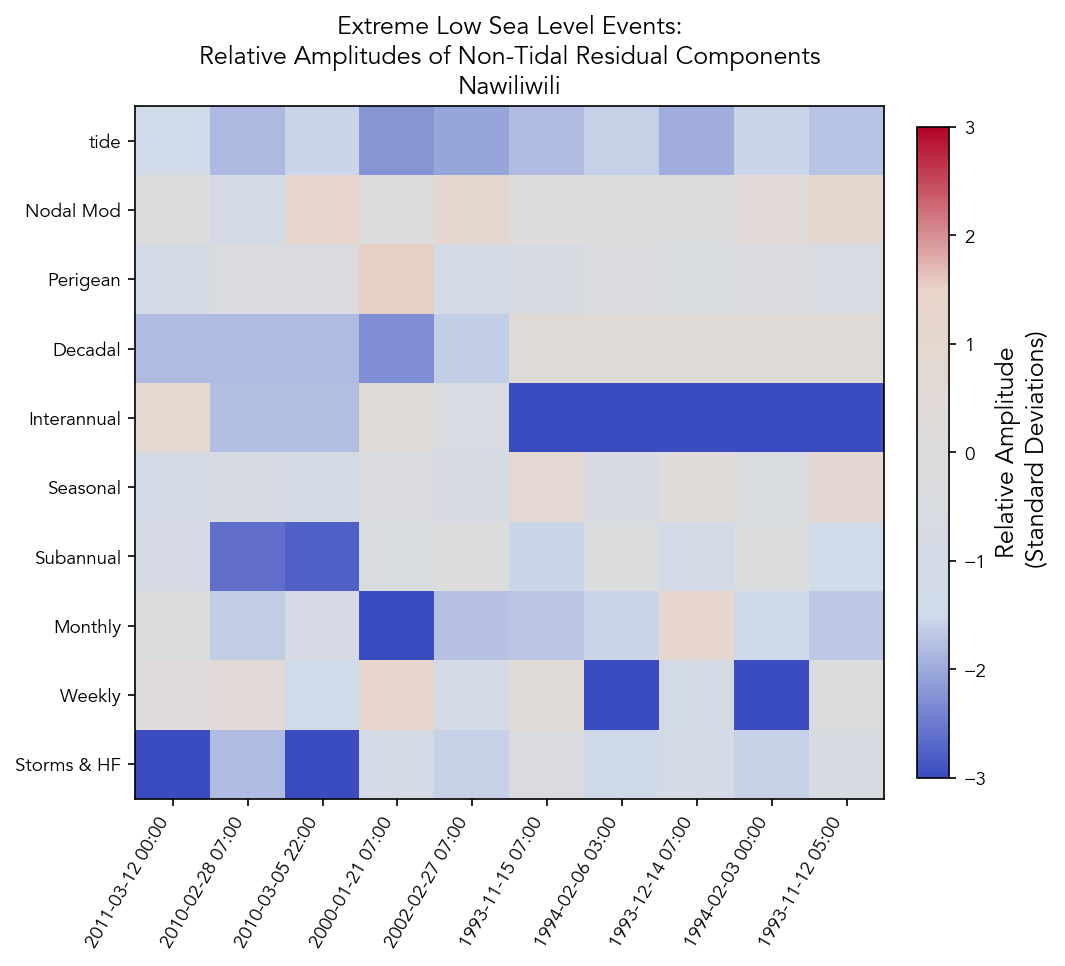

In [67]:
fig,ax = plot_component_amps(extremes_low_relative_to_std, high_or_low = 'low',station_name = station_name)

# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_low.png'
fig.savefig(output_path, bbox_inches='tight')


/Users/jfiedler/Library/CloudStorage/GoogleDrive-jfiedler@hawaii.edu/Shared drives/PI Indicators 2025/SL Indicators/Hawaii_Region_Output/SL_rankings_NTR_relative_amplitudes_top10_Nawiliwili_high.png


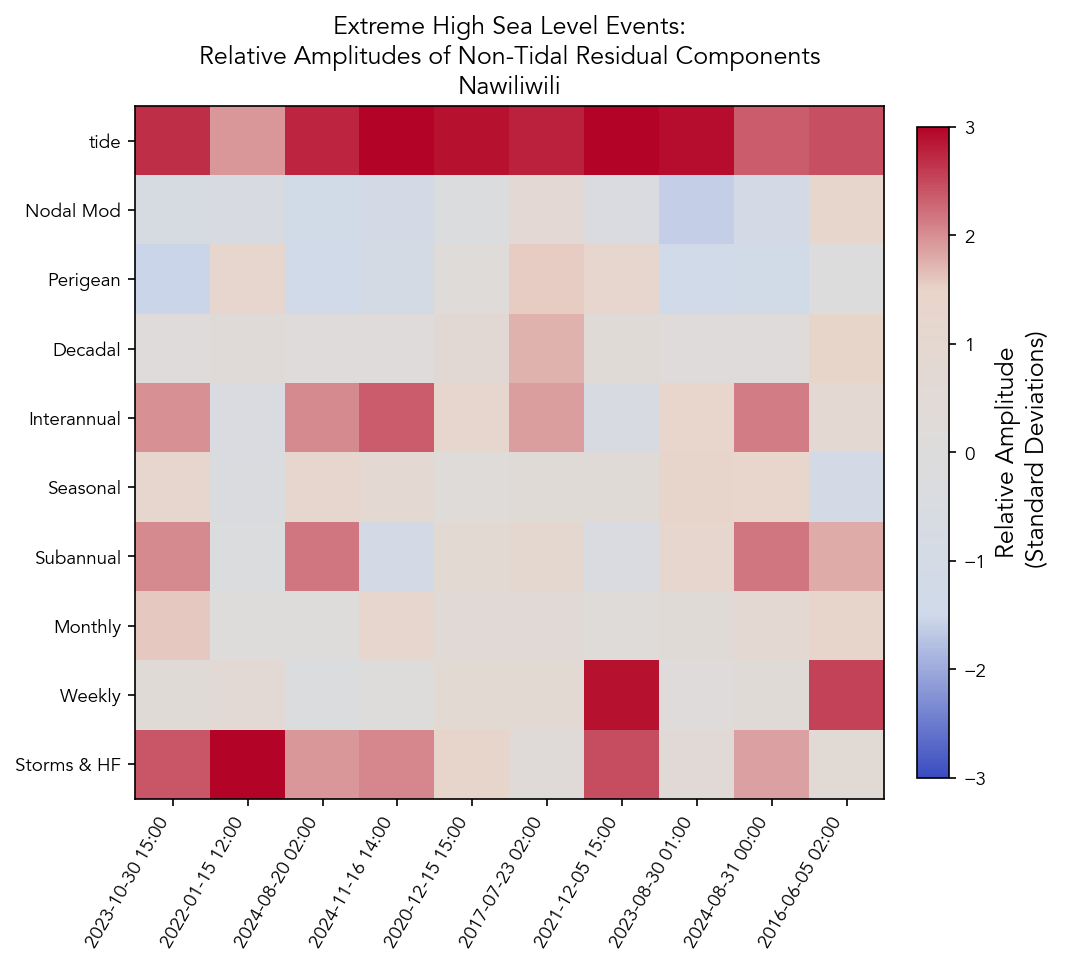

In [68]:
fig, ax = plot_component_amps(extremes_high_relative_to_std, high_or_low = 'high',station_name = station_name)
# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_high.png'

print(output_path)
fig.savefig(output_path, bbox_inches='tight')

## Make a Table


In [69]:
# Now we'll make a nice readable table of the highest and lowest sea level events and their components
# It should be ntr_filtered_extremes_high with the extremes_high_relative_to_std in parentheses

# make a copy of ntr_filtered_extremes_high
extremes_table = ntr_filtered_extremes_high.copy()

# make it relative to mhhw
extremes_table['sea_level'] = extremes_table['sea_level'] - mhhw
extremes_table['tide'] = extremes_table['tide'] - mhhw + extremes_table['Trend']
# extremes_table['tide'] = extremes_table['tide'] - mhhw

# print out only :.2f 
extremes_table = extremes_table.round(4)

#rank according to sea level
extremes_table = extremes_table.sort_values(by='sea_level', ascending=False)






In [70]:
extremes_table

,time,ntr,sea_level,sea_level_detrended,tide,Rank Tide,Trend,Nodal Amp,Nodal Mod,Perigean,Decadal,Interannual,Seasonal,Subannual,Monthly,Weekly,Storms & HF
604181,2023-10-30 15:00:00,0.2202,0.451,0.6885,0.2308,1511.0,1.0175,0.0010,-0.0140,-0.0186,0.0020,0.0604,0.0410,0.0592,0.0335,0.0085,0.0565
588506,2022-01-15 12:00:00,0.3298,0.425,0.6658,0.0952,25246.0,1.0142,-0.0023,-0.0117,0.0140,0.0070,-0.0137,-0.0102,-0.0062,0.0019,0.0115,0.3294
611248,2024-08-20 02:00:00,0.1705,0.415,0.6510,0.2445,945.0,1.0190,0.0021,-0.0243,-0.0158,0.0020,0.0618,0.0437,0.0628,0.0014,-0.0028,0.0454
613372,2024-11-16 14:00:00,0.1179,0.409,0.6446,0.2911,50.0,1.0194,0.0021,-0.0210,-0.0110,0.0020,0.0721,0.0280,-0.0308,0.0261,0.0002,0.0482
579005,2020-12-15 15:00:00,0.1296,0.392,0.6348,0.2624,260.0,1.0122,-0.0048,-0.0042,0.0029,0.0153,0.0361,0.0070,0.0205,0.0120,0.0126,0.0330
549208,2017-07-23 02:00:00,0.1539,0.390,0.6391,0.2361,780.0,1.0059,-0.0124,0.0146,0.0191,0.0365,0.0575,0.0154,0.0279,0.0120,0.0122,0.0077
587525,2021-12-05 15:00:00,0.0883,0.384,0.6250,0.2957,16.0,1.0140,-0.0025,-0.0084,0.0144,0.0077,-0.0192,0.0140,-0.0135,0.0045,0.0508,0.0580
602703,2023-08-30 01:00:00,0.1058,0.378,0.6158,0.2722,198.0,1.0172,0.0007,-0.0308,-0.0165,0.0021,0.0430,0.0498,0.0358,0.0101,0.0017,0.0131
611510,2024-08-31 00:00:00,0.1988,0.374,0.6100,0.1752,6692.0,1.0190,0.0021,-0.0200,-0.0153,0.0020,0.0644,0.0507,0.0633,0.0168,0.0085,0.0437
539296,2016-06-05 02:00:00,0.1966,0.373,0.6242,0.1764,4681.0,1.0038,-0.0111,0.0255,-0.0009,0.0304,0.0259,-0.0350,0.0519,0.0293,0.0444,0.0146


In [71]:
# Now, set everything to MHHW from chosen epoch:
# Create a mapping of time to trendDiff values
trend_mapping = pd.Series(trendDiff.values, index=ntr_data['time'])

# Define columns to adjust
columns_to_adjust = ['ntr']

extremes_table_Epoch = extremes_table.copy()


trend_values = extremes_table_Epoch['time'].map(trend_mapping)
extremes_table_Epoch['ntr'] = extremes_table_Epoch['ntr'] - trend_values
extremes_table_Epoch['tide'] = extremes_table_Epoch['tide'] + trend_values

In [72]:
extremes_table_Epoch['Trend'] = -trend_values 

In [73]:
extremes_table_Epoch

,time,ntr,sea_level,sea_level_detrended,tide,Rank Tide,Trend,Nodal Amp,Nodal Mod,Perigean,Decadal,Interannual,Seasonal,Subannual,Monthly,Weekly,Storms & HF
604181,2023-10-30 15:00:00,0.292204,0.451,0.6885,0.158796,1511.0,0.072004,0.0010,-0.0140,-0.0186,0.0020,0.0604,0.0410,0.0592,0.0335,0.0085,0.0565
588506,2022-01-15 12:00:00,0.398290,0.425,0.6658,0.026710,25246.0,0.068490,-0.0023,-0.0117,0.0140,0.0070,-0.0137,-0.0102,-0.0062,0.0019,0.0115,0.3294
611248,2024-08-20 02:00:00,0.244088,0.415,0.6510,0.170912,945.0,0.073588,0.0021,-0.0243,-0.0158,0.0020,0.0618,0.0437,0.0628,0.0014,-0.0028,0.0454
613372,2024-11-16 14:00:00,0.191965,0.409,0.6446,0.217035,50.0,0.074065,0.0021,-0.0210,-0.0110,0.0020,0.0721,0.0280,-0.0308,0.0261,0.0002,0.0482
579005,2020-12-15 15:00:00,0.195960,0.392,0.6348,0.196040,260.0,0.066360,-0.0048,-0.0042,0.0029,0.0153,0.0361,0.0070,0.0205,0.0120,0.0126,0.0330
549208,2017-07-23 02:00:00,0.213579,0.390,0.6391,0.176421,780.0,0.059679,-0.0124,0.0146,0.0191,0.0365,0.0575,0.0154,0.0279,0.0120,0.0122,0.0077
587525,2021-12-05 15:00:00,0.156570,0.384,0.6250,0.227430,16.0,0.068270,-0.0025,-0.0084,0.0144,0.0077,-0.0192,0.0140,-0.0135,0.0045,0.0508,0.0580
602703,2023-08-30 01:00:00,0.177473,0.378,0.6158,0.200527,198.0,0.071673,0.0007,-0.0308,-0.0165,0.0021,0.0430,0.0498,0.0358,0.0101,0.0017,0.0131
611510,2024-08-31 00:00:00,0.272447,0.374,0.6100,0.101553,6692.0,0.073647,0.0021,-0.0200,-0.0153,0.0020,0.0644,0.0507,0.0633,0.0168,0.0085,0.0437
539296,2016-06-05 02:00:00,0.254057,0.373,0.6242,0.118943,4681.0,0.057457,-0.0111,0.0255,-0.0009,0.0304,0.0259,-0.0350,0.0519,0.0293,0.0444,0.0146


In [74]:
# check if extremes table everything from interdecadal to storms & hf +trend Difference added equals ntr
componentsNTR = ['Decadal', 'Interannual', 'Subannual', 'Monthly', 'Weekly', 'Storms & HF']

componentsNTR_trend = componentsNTR.copy()
componentsNTR_trend.append('Trend')
extremes_table_Epoch['sum'] = extremes_table_Epoch[componentsNTR_trend].sum(axis=1)
#print both columns
extremes_table_Epoch[['ntr','sum']]

# These small differences might come from slightly different tidal coefficients from using the whole timeseries. We'll leave it be for now. To be edited in the future.

,ntr,sum
604181,0.292204,0.292104
588506,0.398290,0.398390
611248,0.244088,0.244188
613372,0.191965,0.191865
579005,0.195960,0.195860
549208,0.213579,0.213479
587525,0.156570,0.156570
602703,0.177473,0.177473
611510,0.272447,0.272347
539296,0.254057,0.253957


In [75]:
# make time the index
# extremes_table = extremes_table.set_index('time')

#change everything except time column to cm
extremes_table_Epoch.iloc[:,1:] = extremes_table_Epoch.iloc[:,1:]*100

#format time to be more readable
# extremes_table['time'] = extremes_table['time'].dt.strftime('%Y-%m-%d %H:%M')

# round to 2 decimal places
extremes_table_Epoch = extremes_table_Epoch.round(1)

# remove sum column
extremes_table_Epoch = extremes_table_Epoch.drop(columns='sum')

# put sea_level in first column
extremes_table_Epoch = extremes_table_Epoch[['time','sea_level','tide','ntr','Trend','Nodal Mod','Decadal','Interannual','Seasonal','Subannual','Monthly','Weekly','Storms & HF']]


In [76]:
extremes_table_Epoch

,time,sea_level,tide,ntr,Trend,Nodal Mod,Decadal,Interannual,Seasonal,Subannual,Monthly,Weekly,Storms & HF
604181,2023-10-30 15:00:00,45.1,15.9,29.2,7.2,-1.4,0.2,6.0,4.1,5.9,3.4,0.8,5.6
588506,2022-01-15 12:00:00,42.5,2.7,39.8,6.8,-1.2,0.7,-1.4,-1.0,-0.6,0.2,1.2,32.9
611248,2024-08-20 02:00:00,41.5,17.1,24.4,7.4,-2.4,0.2,6.2,4.4,6.3,0.1,-0.3,4.5
613372,2024-11-16 14:00:00,40.9,21.7,19.2,7.4,-2.1,0.2,7.2,2.8,-3.1,2.6,0.0,4.8
579005,2020-12-15 15:00:00,39.2,19.6,19.6,6.6,-0.4,1.5,3.6,0.7,2.1,1.2,1.3,3.3
549208,2017-07-23 02:00:00,39.0,17.6,21.4,6.0,1.5,3.6,5.8,1.5,2.8,1.2,1.2,0.8
587525,2021-12-05 15:00:00,38.4,22.7,15.7,6.8,-0.8,0.8,-1.9,1.4,-1.4,0.4,5.1,5.8
602703,2023-08-30 01:00:00,37.8,20.1,17.7,7.2,-3.1,0.2,4.3,5.0,3.6,1.0,0.2,1.3
611510,2024-08-31 00:00:00,37.4,10.2,27.2,7.4,-2.0,0.2,6.4,5.1,6.3,1.7,0.8,4.4
539296,2016-06-05 02:00:00,37.3,11.9,25.4,5.7,2.6,3.0,2.6,-3.5,5.2,2.9,4.4,1.5


In [77]:
clear formatted_table

In [78]:
# now combine extremes_table with extremes_high_relative_to_std
extremes_table_relative = extremes_table_Epoch.copy()
extremes_table_relative = extremes_table_relative.set_index('time')
std_table = extremes_high_relative_to_std.copy()
std_table = std_table.set_index('time')

#sort both on sea_level
extremes_table_relative = extremes_table_relative.sort_values(by='sea_level', ascending=False)
std_table = std_table.sort_values(by='sea_level', ascending=False)

extremes_table_relative

# Find common columns
common_columns = extremes_table_relative.columns.intersection(std_table.columns)

# Select only common columns from both tables
extremes_common = extremes_table_relative[common_columns]
std_common = std_table[common_columns]

# Rename std columns to make them distinct
std_common = std_common.rename(columns={col: f"{col}_std" for col in common_columns})

# Interleave columns (merge column-by-column)
interleaved_columns = sum(zip(extremes_common.columns, std_common.columns), ())  # Creates interleaved column order

# Combine the tables, ensuring interleaved order
formatted_table = pd.concat([extremes_common, std_common], axis=1)[list(interleaved_columns)]

# Add back 'sea_level' and 'ntr' at the front
formatted_table = pd.concat([extremes_table_relative[['sea_level', 'ntr']], formatted_table], axis=1)

#drop sea_level_std column
formatted_table = formatted_table.drop(columns=['sea_level_std','sea_level'])

# add 'sea level' column back in front
formatted_table.insert(0, 'sea_level', extremes_table_relative['sea_level'])

# remove 'Trend_std' column if it exists
if 'Trend_std' in formatted_table.columns:
    formatted_table = formatted_table.drop(columns=['Trend_std'])

# format all to 1 decimal place
formatted_table = formatted_table.round(1)

formatted_table


,sea_level,ntr,tide,tide_std,Trend,Nodal Mod,Nodal Mod_std,Decadal,Decadal_std,Interannual,...,Seasonal,Seasonal_std,Subannual,Subannual_std,Monthly,Monthly_std,Weekly,Weekly_std,Storms & HF,Storms & HF_std
time,,,,,,,,,,,,,,,,,,,,,
2023-10-30 15:00:00,45.1,29.2,15.9,2.7,7.2,-1.4,-0.7,0.2,0.1,6.0,...,4.1,1.2,5.9,2.0,3.4,1.6,0.8,0.5,5.6,2.4
2022-01-15 12:00:00,42.5,39.8,2.7,1.9,6.8,-1.2,-0.6,0.7,0.3,-1.4,...,-1.0,-0.3,-0.6,-0.2,0.2,0.1,1.2,0.7,32.9,14.0
2024-08-20 02:00:00,41.5,24.4,17.1,2.8,7.4,-2.4,-1.3,0.2,0.1,6.2,...,4.4,1.2,6.3,2.2,0.1,0.1,-0.3,-0.2,4.5,1.9
2024-11-16 14:00:00,40.9,19.2,21.7,3.0,7.4,-2.1,-1.1,0.2,0.1,7.2,...,2.8,0.8,-3.1,-1.1,2.6,1.2,0.0,0.0,4.8,2.1
2020-12-15 15:00:00,39.2,19.6,19.6,2.9,6.6,-0.4,-0.2,1.5,0.7,3.6,...,0.7,0.2,2.1,0.7,1.2,0.6,1.3,0.7,3.3,1.4
2017-07-23 02:00:00,39.0,21.4,17.6,2.8,6.0,1.5,0.8,3.6,1.8,5.8,...,1.5,0.4,2.8,1.0,1.2,0.6,1.2,0.7,0.8,0.3
2021-12-05 15:00:00,38.4,15.7,22.7,3.1,6.8,-0.8,-0.4,0.8,0.4,-1.9,...,1.4,0.4,-1.4,-0.5,0.4,0.2,5.1,2.9,5.8,2.5
2023-08-30 01:00:00,37.8,17.7,20.1,2.9,7.2,-3.1,-1.6,0.2,0.1,4.3,...,5.0,1.4,3.6,1.2,1.0,0.5,0.2,0.1,1.3,0.6
2024-08-31 00:00:00,37.4,27.2,10.2,2.4,7.4,-2.0,-1.0,0.2,0.1,6.4,...,5.1,1.4,6.3,2.2,1.7,0.8,0.8,0.5,4.4,1.9


In [79]:
formatted_table_time = formatted_table.reset_index()
formatted_table_time['time'] = formatted_table_time['time'].dt.strftime('%Y-%m-%d %H:%M')
formatted_table_time = formatted_table_time.rename(columns={'Storms & HF_std': 'Storms_std'})

formatted_table_time.columns


Index(['time', 'sea_level', 'ntr', 'tide', 'tide_std', 'Trend', 'Nodal Mod',
       'Nodal Mod_std', 'Decadal', 'Decadal_std', 'Interannual',
       'Interannual_std', 'Seasonal', 'Seasonal_std', 'Subannual',
       'Subannual_std', 'Monthly', 'Monthly_std', 'Weekly', 'Weekly_std',
       'Storms & HF', 'Storms_std'],
      dtype='object')

In [80]:
station

1611400

In [81]:
#make a pretty pdf of the table with great_tables
from great_tables import GT, html, style, loc

# make time a column again
formatted_table_time = formatted_table.reset_index()
# make time a string
formatted_table_time['time'] = formatted_table_time['time'].dt.strftime('%Y-%m-%d %H:%M')

#change 'Storms & HF_std' to 'Storms_std'
formatted_table_time = formatted_table_time.rename(columns={'Storms & HF_std': 'Storms_std'})

# ntr_columns = ['Interdecadal','Interdecadal_std',
#                'Decadal','Decadal_std',
#                'Interannual','Interannual_std',
#                'Seasonal','Seasonal_std',
#                'Intraannual','Intraannual_std',
#                'Weekly','Weekly_std',
#                'Storms & HF','Storms_std']

ntr_columns = [ 'Trend',
                'Decadal','Decadal_std',
               'Interannual','Interannual_std',
               'Seasonal','Seasonal_std',
               'Intraannual','Intraannual_std',
               'Monthly','Monthly_std',
               'Weekly','Weekly_std',
               'Storms & HF','Storms_std']

# ntr_columns = ['Nodal','Nodal_std']

# col_width_dict = #make dictionary using ntr_columns
col_width_dict = {col: "30px" for col in ntr_columns}
#add time to col_width_dict
col_width_dict['time'] = "120px"
col_width_dict['Nodal Amp'] = "20px"

std_columns = [col for col in formatted_table_time.columns if 'std' in col]

# Create a Table object
table = (
    GT(formatted_table_time)
    .tab_options(table_font_size="12px")
    .cols_width(cases={"time" : "150px"})
        .cols_label(
        time=html(''),
        ntr=html('NTR'),
        sea_level=html('Sea Level'),
        tide=html('Tide'),
        tide_std=html('(σ̂)'),
        Decadal_std=html('(σ̂)'),
        Interannual_std=html('(σ̂)'),
        Interannual=html('Inter-\nannual'),
        Seasonal_std=html('(σ̂)'),
        Subannual_std=html('(σ̂)'),
        Subannual=html('Intra-\nannual'),
        Monthly_std=html('(σ̂)'),
        Monthly=html('Monthly'),
        Weekly_std=html('(σ̂)'),
        Storms_std=html('(σ̂)'),
        **{"Nodal Mod_std": html('(σ̂)')},  # Use quotes for column names with spaces
        #  **{"Nodal Amp_std": html('(σ̂)')},  # Use quotes for column names with spaces
        # tide=html('Tide')
        )
        # .tab_spanner(
            # label="Non-Tidal Residual", columns=ntr_columns)
        .tab_header(
            title=station_name + ' (' + str(station) + ')', subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components')
        .tab_source_note(
            source_note='Data are in cm, relative to MHHW. The (σ̂) represents the magnitude of each component relative to its standard deviation. Trend is the difference between the epoch-derived trend and the trend on the full dataset; the tide and NTR have been offset by this amount to align with the NTDE datum. Data source: NOAA CO-OPS Hourly Water Level. Time is GMT.')
        # .tab_source_note(
            # source_note='Data: ' +ds.attrs['title'] + ', ' + ds.attrs['publisher_url'] + ', ' + 'UHSLC Station ID: ' + str(station))
        # .fmt_number(
            # columns=std_columns, pattern='({x})',decimals=1)
        .data_color(columns=std_columns, palette='RdBu',reverse=True,domain=(-4,4),alpha=0.5)

)

# save the table to a pdf
output_path = Path(output_dir, f'1.5.2_SL_rankings_NTR_relative_amplitudes_top10_{station_name}_high_table.pdf')
table.save(str(output_path))
# save the table to a png
output_path = Path(output_dir, f'1.5.2_SL_rankings_NTR_relative_amplitudes_top10_{station_name}_high_table.png')
table.save(str(output_path))

GT(_tbl_data=               time  sea_level   ntr  tide  tide_std  Trend  Nodal Mod  \
0  2023-10-30 15:00       45.1  29.2  15.9       2.7    7.2       -1.4   
1  2022-01-15 12:00       42.5  39.8   2.7       1.9    6.8       -1.2   
2  2024-08-20 02:00       41.5  24.4  17.1       2.8    7.4       -2.4   
3  2024-11-16 14:00       40.9  19.2  21.7       3.0    7.4       -2.1   
4  2020-12-15 15:00       39.2  19.6  19.6       2.9    6.6       -0.4   
5  2017-07-23 02:00       39.0  21.4  17.6       2.8    6.0        1.5   
6  2021-12-05 15:00       38.4  15.7  22.7       3.1    6.8       -0.8   
7  2023-08-30 01:00       37.8  17.7  20.1       2.9    7.2       -3.1   
8  2024-08-31 00:00       37.4  27.2  10.2       2.4    7.4       -2.0   
9  2016-06-05 02:00       37.3  25.4  11.9       2.5    5.7        2.6   

   Nodal Mod_std  Decadal  Decadal_std  ...  Seasonal  Seasonal_std  \
0           -0.7      0.2          0.1  ...       4.1           1.2   
1           -0.6      0.7          0.3  ...      -1.0          -0.3   
2           -1.3      0.2          0.1  ...       4.4           1.2   
3           -1.1      0.2          0.1  ...       2.8           0.8   
4           -0.2      1.5          0.7  ...       0.7           0.2   
5            0.8      3.6          1.8  ...       1.5           0.4   
6           -0.4      0.8          0.4  ...       1.4           0.4   
7           -1.6      0.2          0.1  ...       5.0           1.4   
8           -1.0      0.2          0.1  ...       5.1           1.4   
9            1.3      3.0          1.5  ...      -3.5          -1.0   

   Subannual  Subannual_std  Monthly  Monthly_std  Weekly  Weekly_std  \
0        5.9            2.0      3.4          1.6     0.8         0.5   
1       -0.6           -0.2      0.2          0.1     1.2         0.7   
2        6.3            2.2      0.1          0.1    -0.3        -0.2   
3       -3.1           -1.1      2.6          1.2     0.0         0.0   
4        2.1            0.7      1.2          0.6     1.3         0.7   
5        2.8            1.0      1.2          0.6     1.2         0.7   
6       -1.4           -0.5      0.4          0.2     5.1         2.9   
7        3.6            1.2      1.0          0.5     0.2         0.1   
8        6.3            2.2      1.7          0.8     0.8         0.5   
9        5.2            1.8      2.9          1.4     4.4         2.5   

   Storms & HF  Storms_std  
0          5.6         2.4  
1         32.9        14.0  
2          4.5         1.9  
3          4.8         2.1  
4          3.3         1.4  
5          0.8         0.3  
6          5.8         2.5  
7          1.3         0.6  
8          4.4         1.9  
9          1.5         0.6  

[10 rows x 22 columns], _body=<great_tables._gt_data.Body object at 0x19541cd10>, _boxhead=Boxhead([ColInfo(var='time', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text=''), column_align='right', column_width='150px'), ColInfo(var='sea_level', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Sea Level'), column_align='right', column_width=None), ColInfo(var='ntr', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='NTR'), column_align='right', column_width=None), ColInfo(var='tide', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Tide'), column_align='right', column_width=None), ColInfo(var='tide_std', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='(σ̂)'), column_align='right', column_width=None), ColInfo(var='Trend', type=<ColInfoTypeEnum.default: 1>, column_label='Trend', column_align='right', column_width=None), ColInfo(var='Nodal Mod', type=<ColInfoTypeEnum.default: 1>, column_label='Nodal Mod', column_align='right', column_width=None), ColInfo(var='Nodal Mod_std', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='(σ̂)'), column_align='right', column_width=None), ColInfo(var='Decadal', type=<ColInfoTypeEnum.default: 1>, column_label='Decadal', column_align='right', column_width=None), 

In [82]:
formatted_table_time

,time,sea_level,ntr,tide,tide_std,Trend,Nodal Mod,Nodal Mod_std,Decadal,Decadal_std,...,Seasonal,Seasonal_std,Subannual,Subannual_std,Monthly,Monthly_std,Weekly,Weekly_std,Storms & HF,Storms_std
0,2023-10-30 15:00,45.1,29.2,15.9,2.7,7.2,-1.4,-0.7,0.2,0.1,...,4.1,1.2,5.9,2.0,3.4,1.6,0.8,0.5,5.6,2.4
1,2022-01-15 12:00,42.5,39.8,2.7,1.9,6.8,-1.2,-0.6,0.7,0.3,...,-1.0,-0.3,-0.6,-0.2,0.2,0.1,1.2,0.7,32.9,14.0
2,2024-08-20 02:00,41.5,24.4,17.1,2.8,7.4,-2.4,-1.3,0.2,0.1,...,4.4,1.2,6.3,2.2,0.1,0.1,-0.3,-0.2,4.5,1.9
3,2024-11-16 14:00,40.9,19.2,21.7,3.0,7.4,-2.1,-1.1,0.2,0.1,...,2.8,0.8,-3.1,-1.1,2.6,1.2,0.0,0.0,4.8,2.1
4,2020-12-15 15:00,39.2,19.6,19.6,2.9,6.6,-0.4,-0.2,1.5,0.7,...,0.7,0.2,2.1,0.7,1.2,0.6,1.3,0.7,3.3,1.4
5,2017-07-23 02:00,39.0,21.4,17.6,2.8,6.0,1.5,0.8,3.6,1.8,...,1.5,0.4,2.8,1.0,1.2,0.6,1.2,0.7,0.8,0.3
6,2021-12-05 15:00,38.4,15.7,22.7,3.1,6.8,-0.8,-0.4,0.8,0.4,...,1.4,0.4,-1.4,-0.5,0.4,0.2,5.1,2.9,5.8,2.5
7,2023-08-30 01:00,37.8,17.7,20.1,2.9,7.2,-3.1,-1.6,0.2,0.1,...,5.0,1.4,3.6,1.2,1.0,0.5,0.2,0.1,1.3,0.6
8,2024-08-31 00:00,37.4,27.2,10.2,2.4,7.4,-2.0,-1.0,0.2,0.1,...,5.1,1.4,6.3,2.2,1.7,0.8,0.8,0.5,4.4,1.9
9,2016-06-05 02:00,37.3,25.4,11.9,2.5,5.7,2.6,1.3,3.0,1.5,...,-3.5,-1.0,5.2,1.8,2.9,1.4,4.4,2.5,1.5,0.6


This table is trying to be the best at both worlds but is probably too complicated. A simpler version:

In [83]:
# make time a column again
formatted_table_time = extremes_table_relative.reset_index()
# make time a string
formatted_table_time['time'] = formatted_table_time['time'].dt.strftime('%Y-%m-%d %H:%M')


# col_width_dict = #make dictionary using ntr_columns
col_width_dict = {col: "5%" for col in ntr_columns}
#add time to col_width_dict
# col_width_dict['time'] = "120px"

std_columns = [col for col in formatted_table_time.columns if 'std' in col]

timeframes_str = "; ".join([f"{k}: {v}" for k, v in timeframes.items()])

# Create a Table object
(
    GT(formatted_table_time)
    .tab_options(table_font_size="13px")
    .cols_width(cases={"time": "150px"})
    .cols_label(
        time = html(''),
        ntr=html('NTR'), sea_level=html('Sea Level'), 
        # Interdecadal = html('Inter-\ndecadal'),
        Interannual=html('Inter-\nannual'),Subannual=html('Sub-\nannual'),
        tide=html('Tide'))
        .tab_spanner(
            label="Non-Tidal Residual", columns=componentsNTR)
        .tab_header(
            title=station_name + ' (' + str(station) + ')',subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components')
        .tab_source_note(
            source_note='Data are in cm, relative to MHHW. '
            'Trend is the difference between the epoch-derived trend and the trend on the full dataset; the tide and NTR have been offset by this amount to align with the NTDE datum.The Nodal component shown here is included in the Tide component, representing the nodal modulation of the tide at the given hour. '
            'The timescales of the NTR components are as follows: ' + timeframes_str + '.')
            
        .tab_source_note(
            # source_note='Data: ' +ds.attrs['title'] + ', ' + ds.attrs['publisher_url'] + ', ' + 'UHSLC Station ID: ' + str(station))
            source_note = 'Data: NOAA CO-OPS Hourly Water Level, time in GMT')
        .fmt_number(
            columns=std_columns, pattern='({x})',decimals=1)
        .data_color(columns=std_columns, palette='RdBu',reverse=True,domain=(-4,4),alpha=0.5)
)

GT(_tbl_data=               time  sea_level  tide   ntr  Trend  Nodal Mod  Decadal  \
0  2023-10-30 15:00       45.1  15.9  29.2    7.2       -1.4      0.2   
1  2022-01-15 12:00       42.5   2.7  39.8    6.8       -1.2      0.7   
2  2024-08-20 02:00       41.5  17.1  24.4    7.4       -2.4      0.2   
3  2024-11-16 14:00       40.9  21.7  19.2    7.4       -2.1      0.2   
4  2020-12-15 15:00       39.2  19.6  19.6    6.6       -0.4      1.5   
5  2017-07-23 02:00       39.0  17.6  21.4    6.0        1.5      3.6   
6  2021-12-05 15:00       38.4  22.7  15.7    6.8       -0.8      0.8   
7  2023-08-30 01:00       37.8  20.1  17.7    7.2       -3.1      0.2   
8  2024-08-31 00:00       37.4  10.2  27.2    7.4       -2.0      0.2   
9  2016-06-05 02:00       37.3  11.9  25.4    5.7        2.6      3.0   

   Interannual  Seasonal  Subannual  Monthly  Weekly  Storms & HF  
0          6.0       4.1        5.9      3.4     0.8          5.6  
1         -1.4      -1.0       -0.6      0.2     1.2         32.9  
2          6.2       4.4        6.3      0.1    -0.3          4.5  
3          7.2       2.8       -3.1      2.6     0.0          4.8  
4          3.6       0.7        2.1      1.2     1.3          3.3  
5          5.8       1.5        2.8      1.2     1.2          0.8  
6         -1.9       1.4       -1.4      0.4     5.1          5.8  
7          4.3       5.0        3.6      1.0     0.2          1.3  
8          6.4       5.1        6.3      1.7     0.8          4.4  
9          2.6      -3.5        5.2      2.9     4.4          1.5  , _body=<great_tables._gt_data.Body object at 0x1956285d0>, _boxhead=Boxhead([ColInfo(var='time', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text=''), column_align='right', column_width='150px'), ColInfo(var='sea_level', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Sea Level'), column_align='right', column_width=None), ColInfo(var='tide', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Tide'), column_align='right', column_width=None), ColInfo(var='ntr', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='NTR'), column_align='right', column_width=None), ColInfo(var='Trend', type=<ColInfoTypeEnum.default: 1>, column_label='Trend', column_align='right', column_width=None), ColInfo(var='Nodal Mod', type=<ColInfoTypeEnum.default: 1>, column_label='Nodal Mod', column_align='right', column_width=None), ColInfo(var='Decadal', type=<ColInfoTypeEnum.default: 1>, column_label='Decadal', column_align='right', column_width=None), ColInfo(var='Interannual', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Inter-\nannual'), column_align='right', column_width=None), ColInfo(var='Subannual', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Sub-\nannual'), column_align='right', column_width=None), ColInfo(var='Monthly', type=<ColInfoTypeEnum.default: 1>, column_label='Monthly', column_align='right', column_width=None), ColInfo(var='Weekly', type=<ColInfoTypeEnum.default: 1>, column_label='Weekly', column_align='right', column_width=None), ColInfo(var='Storms & HF', type=<ColInfoTypeEnum.default: 1>, column_label='Storms & HF', column_align='right', column_width=None), ColInfo(var='Seasonal', type=<ColInfoTypeEnum.default: 1>, column_label='Seasonal', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x1945f3190>, _spanners=Spanners([SpannerInfo(spanner_id='Non-Tidal Residual', spanner_level=0, spanner_label='Non-Tidal Residual', spanner_units=None, spanner_pattern=None, vars=['Decadal', 'Interannual', 'Subannual', 'Monthly', 'Weekly', 'Storms & HF'], built=None)]), _heading=Heading(title='Nawiliwili (1611400)', subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components', preheader=None), _stubhead=None, _source_notes=['Data are in cm, relative to MHHW. Trend is the difference between the epoch-derived trend and the trend on the full dataset; the tide and NTR have been offset by this amount 

## Make a map

In [84]:
ntr_cumsum_stds.diff()

Seasonal            NaN
Decadal        0.005633
Interannual    0.010972
Subannual      0.009389
Monthly        0.004699
Weekly         0.002806
Storms & HF    0.004115
dtype: float64

/var/folders/qp/nn19rcjs5bdcdvxmff5bd3pr0000gn/T/ipykernel_77982/89822144.py:10: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`



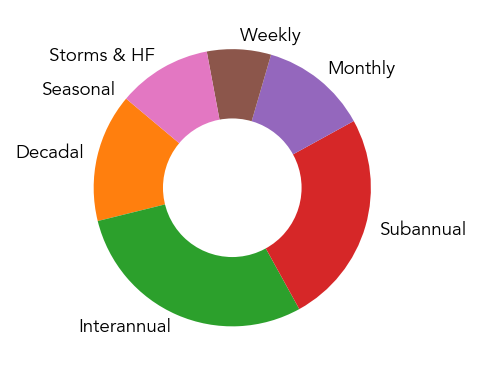

In [85]:
# let's turn our our bar chart into a pie chart
# we'll use what we used previously to get the std of each component
# ntr_cumsum_stds
# ntr_var = ntr_filtered['ntr'].var()

# ntr_component_vars['covariance'] = ntr_var - sum_ntr_var

# get the difference between each successive component
ntr_cumsum_diff = ntr_cumsum_stds.diff()
ntr_cumsum_diff[0] = 0
# ntr_cumsum_diff['NTR Trend'] = ntr_cumsum_stds['NTR Trend']

# ntr_cumsum_diff['Interdecadal'] = ntr_cumsum_stds['Interdecadal']

#reverse the order of the components
# ntr_cumsum_stds = ntr_cumsum_stds[::-1]
# ntr_component_vars = ntr_component_vars[::-1]

# # make a pie chart, ignoring co-variance for now because omg
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(ntr_cumsum_diff, labels=ntr_cumsum_diff.index, startangle=140)
center_circle = plt.Circle((0, 0), 0.5, fc='white')  # Creates a white hole
ax.add_patch(center_circle)



In [86]:
ds

<xarray.Dataset> Size: 62MB
Dimensions:          (station_id: 7, time: 972999)
Coordinates:
  * time             (time) datetime64[ns] 8MB 1914-01-01T10:00:00 ... 2024-1...
  * station_id       (station_id) int64 56B 1617760 1619910 ... 1612340 1611400
Data variables:
    sea_level        (station_id, time) float64 54MB ...
    station_name     (station_id) <U27 756B ...
    station_country  (station_id) <U3 84B ...
    lat              (station_id) float64 56B ...
    lon              (station_id) float64 56B ...
    MHHW             (station_id) float64 56B ...
    MSL              (station_id) float64 56B ...
    MLLW             (station_id) float64 56B ...

In [87]:
# make a locations dictionary, with stations: (lat, lon)
# from ds
stations = ds['station_name'].values
lons = ds['lon'].values
lats = ds['lat'].values

locations = {station: (lon,lat) for station, lat, lon in zip(stations, lats, lons)}
locations_id = {id: (lon,lat) for id, (lon,lat) in zip(station_ids, locations.values())}

# make pie_data dictionary
ntr_component_stds_subset = ntr_component_stds.copy()
ntr_component_stds_subset = ntr_component_stds_subset.drop(['sea_level', 'tide'])
pie_data = {station: ntr_component_stds_subset for station in stations}


locations
station_ids

array([1617760, 1619910, 1617433, 1612480, 1615680, 1612340, 1611400])

In [88]:
# make a new pie data dictionary that calls from ntr_data/ntr_{station:03d}_component_stds.csv
pie_data = {}
ntr_mag = {}
for sid in station_ids:
    station_path = Path(data_dir, f'ntr_data/ntr_{sid:03d}_component_stds.csv')
    if not station_path.exists():
        # pie_data[station] = zeros the size of ntr_component_stds
        pie_data[sid] = ntr_component_stds * 0
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    if 'ntr' in station_data.index:
        ntr_mag[sid] = station_data.loc['ntr'].values[0]
        station_data = station_data.drop(index='ntr')
    # print(station_data)
    # ntr_mag[station] = station_data['ntr']
    station_data = station_data.drop(index=['sea_level','tide'])
    # remove 'sea_level' and 'tide' columns
    pie_data[sid] = station_data.squeeze()



/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning:

invalid value encountered in create_collection

/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-

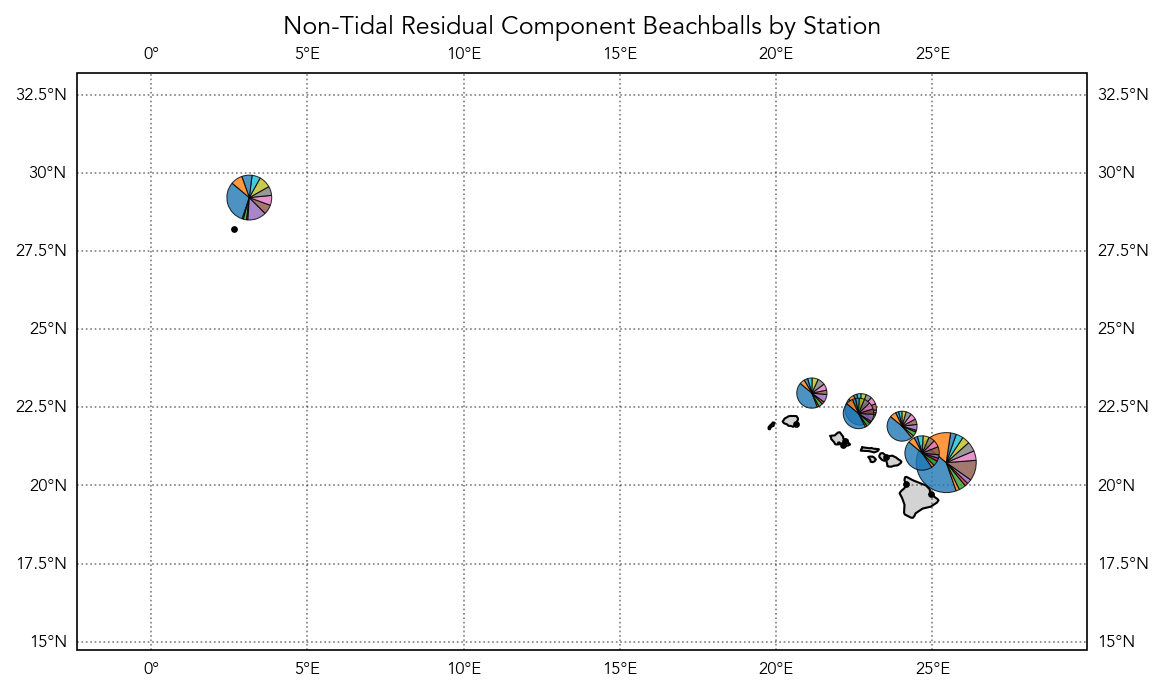

In [89]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

crs = ccrs.PlateCarree(central_longitude=180)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection': crs})
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, color='lightgrey')

# cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2024.nc')

xlims = [ds['lon'].min()-5, ds['lon'].max()+5]
ylims = [ds['lat'].min()-5, ds['lat'].max()+5]
xlims_360 = [x + 360 if x < 0 else x for x in xlims]

ax.set_extent([xlims_360[0], xlims_360[1], ylims[0], ylims[1]], crs=ccrs.PlateCarree())

def plot_pie_inset(data, lon, lat, station, ax, width, alpha=1):
    # Convert lat/lon to map display coordinates
    x, y = ax.projection.transform_point(lon, lat, ccrs.PlateCarree())[:2]
    y = y + 1 
    x = x + 0.5
    pie_ax = inset_axes(ax, width=width, height=width, loc=10, 
                        bbox_to_anchor=(x, y), bbox_transform=ax.transData, borderpad=0)
    pie_ax.set_facecolor('none')  # Fully transparent background

    wedges, texts, autotexts = pie_ax.pie(data, autopct='',startangle=140, 
                                          wedgeprops={'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 0.5})
    
    # pie_ax.pie(data, startangle=140)  # Draw pie chart
    pie_ax.set_xticks([])
    pie_ax.set_yticks([])
    pie_ax.set_frame_on(False)  # Hide frame
    # add title
    # pie_ax.set_title(station, fontsize=8)

for station, data in pie_data.items():
    lon, lat = locations_id[station]
    # if data is all zeros, skip
    if np.all(data == 0):
        continue
    width = 0.5*(ntr_mag[station]/max(ntr_mag.values()))

    plot_pie_inset(data, lon, lat, station,ax, width=width)

ax.scatter(lons, lats, color='black', s=5, label='Station', transform=ccrs.PlateCarree())


#add grid
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                  alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks(),crs=crs)
#make all labels tiny
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}


# Will need to fix longitude labels!!
ax.set_title('Non-Tidal Residual Component Beachballs by Station')

glue('beachballs',fig,display=False)


```{glue:figure}beachballs
This is sort of silly - maybe we can break this up and look at things by component...
```

In [90]:
# # make a new pie data dictionary that calls from ntr_data/ntr_{station:03d}_component_stds.csv
# pie_data = {}

# make a dataframe of the ntr_component_stds, with each station as a column
ntr_component_stds_df = pd.DataFrame(columns=station_ids)
# ntr_component_stds_df = ntr_component_stds_df.append(ntr_component_stds, ignore_index=True)
for sid in station_ids:
    station_path = Path(data_dir, f'ntr_data/ntr_{sid:03d}_component_stds.csv')
    if not station_path.exists():
#         # pie_data[station] = zeros the size of ntr_component_stds
        # pie_data[station] = ntr_component_stds * 0
        #remove station
        # ntr_component_stds_df = ntr_component_stds_df.drop(columns=station, errors='ignore')
        # lons = np.delete(lons, station_index)
        # lats = np.delete(lats, station_index)
        
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    ntr_component_stds_df[sid] = station_data.squeeze()



#replace nans with 0
ntr_component_stds_df = ntr_component_stds_df.fillna(0).infer_objects(copy=False)
#change 'tide' to 'Tide' in index
ntr_component_stds_df = ntr_component_stds_df.rename(index={'tide':'Tide'})

In [91]:
ntr_component_stds_df

,1617760,1619910,1617433,1612480,1615680,1612340,1611400
ntr,0.127101,0.094974,0.072744,0.066589,0.063464,0.064522,0.063950
sea_level,0.246622,0.153437,0.218311,0.212881,0.224930,0.196618,0.189239
sea_level_detrended,0.242591,0.149783,0.215805,0.211435,0.220852,0.191431,0.185499
Tide,0.224207,0.116506,0.202450,0.201481,0.210567,0.181286,0.174117
Nodal Amp,0.010750,0.004213,0.012860,0.010607,0.011833,0.008466,0.008281
Nodal Mod,0.021912,0.011250,0.022950,0.023244,0.022836,0.019615,0.019317
Perigean,0.010409,0.004718,0.013785,0.010513,0.008947,0.009386,0.012213
Trend,0.014333,0.065040,0.015113,0.012228,0.029736,0.035146,0.037431
Decadal,0.064386,0.033562,0.036231,0.029707,0.027730,0.025358,0.020799
Interannual,0.030039,0.034615,0.031111,0.033616,0.031638,0.031585,0.030512


In [92]:
ntr_component_stds_df_mags = ntr_component_stds_df.drop(index=['sea_level','ntr','sea_level_detrended']).copy()
ntr_component_cbar_min = ntr_component_stds_df_mags.min().min()
ntr_component_cbar_max = ntr_component_stds_df_mags.max().max()


In [93]:
print("All component names:")
print(ntr_component_stds_df.index.tolist())
print("\nComponent magnitudes after removing sea_level, ntr, sea_level_detrended:")
print(ntr_component_stds_df_mags.index.tolist())
print("\nComponent values range:")
for comp in ntr_component_stds_df_mags.index:
    values = ntr_component_stds_df_mags.loc[comp]
    print(f"{comp}: {values.min():.4f} - {values.max():.4f}")

All component names:
['ntr', 'sea_level', 'sea_level_detrended', 'Tide', 'Nodal Amp', 'Nodal Mod', 'Perigean', 'Trend', 'Decadal', 'Interannual', 'Seasonal', 'Subannual', 'Monthly', 'Weekly', 'Storms & HF']

Component magnitudes after removing sea_level, ntr, sea_level_detrended:
['Tide', 'Nodal Amp', 'Nodal Mod', 'Perigean', 'Trend', 'Decadal', 'Interannual', 'Seasonal', 'Subannual', 'Monthly', 'Weekly', 'Storms & HF']

Component values range:
Tide: 0.1165 - 0.2242
Nodal Amp: 0.0042 - 0.0129
Nodal Mod: 0.0112 - 0.0232
Perigean: 0.0047 - 0.0138
Trend: 0.0122 - 0.0650
Decadal: 0.0208 - 0.0644
Interannual: 0.0300 - 0.0346
Seasonal: 0.0268 - 0.0355
Subannual: 0.0214 - 0.0425
Monthly: 0.0163 - 0.0295
Weekly: 0.0150 - 0.0359
Storms & HF: 0.0235 - 0.0947


In [94]:
ntr_component_stds_df_mags.loc[componentsNTR]


,1617760,1619910,1617433,1612480,1615680,1612340,1611400
Decadal,0.064386,0.033562,0.036231,0.029707,0.027730,0.025358,0.020799
Interannual,0.030039,0.034615,0.031111,0.033616,0.031638,0.031585,0.030512
Subannual,0.023948,0.042523,0.026545,0.024291,0.021372,0.024210,0.029119
Monthly,0.023024,0.029467,0.025963,0.019211,0.016299,0.016915,0.021124
Weekly,0.018046,0.035853,0.014957,0.016079,0.015884,0.015117,0.017533
Storms & HF,0.094677,0.041004,0.029408,0.027034,0.031521,0.032099,0.023509


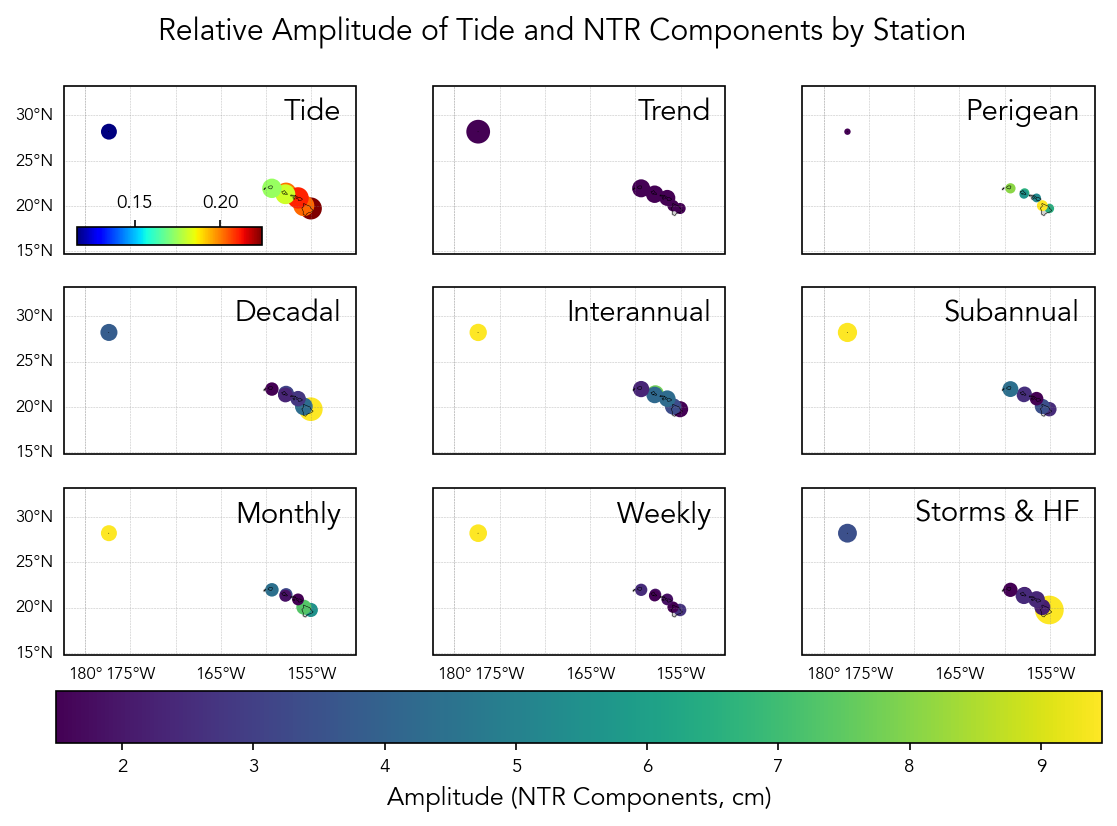

In [95]:
#Repeat the map exercise using only the amplitudes of each component at each station, will just be a scatter plot
from maps import plot_thin_map_hawaii, get_stationinfo
from matplotlib import ticker as mticker

fig, axes = plt.subplots(3, 3, figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

ntr_component_names = ntr_component_stds_df.index
#remove sea level and ntr
ntr_component_names = ntr_component_names.drop(['sea_level','ntr','sea_level_detrended'])

colors = plt.cm.tab20(np.linspace(0, 1, 20))

# remove columns of ntr_component_stds_df if all missing data or all zeroes
# ntr_component_stds_df = ntr_component_stds_df.dropna(axis=1, how='all')
# ntr_component_stds_df = ntr_component_stds_df.loc[:, (ntr_component_stds_df != 0).any(axis=0)]

# Store scatter plots for colorbar reference
scatter_plots = []
tide_scatter = None  # Store Tide scatter plot separately

# Create separate colorbar ranges
tide_cbar_min = ntr_component_stds_df.loc['Tide'].min()
tide_cbar_max = ntr_component_stds_df.loc['Tide'].max()

# For non-Tide components, exclude Tide from min/max calculation
non_tide_components = ntr_component_stds_df_mags.loc[componentsNTR]
ntr_component_cbar_min = non_tide_components.min().min()
ntr_component_cbar_max = non_tide_components.max().max()

componentsToPlot = ['Tide','Trend','Perigean'] +  componentsNTR

for i, ax in enumerate(axes.flat):
    if i >= len(componentsToPlot):
        ax.set_visible(False)
        continue
        
    ax, gl = plot_thin_map_hawaii(ax) ## THIN MAP HAWAII IS YOUR FIRST MISTAKE, THIS WON'T WORK FOR TONGA FRIEND
    # ensure gl on the longitudes past 180
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 5))
    gl.xlabels = [str(x) for x in np.arange(-180, 181, 5)]
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 5))
    gl.ylabels = [str(y) for y in np.arange(-90, 91, 5)]

    crs = ccrs.PlateCarree()

    xlims = [ds['lon'].min()-5, ds['lon'].max()+5]
    ylims = [ds['lat'].min()-5, ds['lat'].max()+5]

    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=ccrs.PlateCarree())
    # ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    # component_name = ntr_component_names[i]
    component_name = componentsToPlot[i]
    ntrmag = ntr_component_stds_df.loc[component_name]

    # plot only stations with non-zero values
    valid_stations = ntrmag[ntrmag > 0].index
    ntrmag = ntrmag[valid_stations]
    lons = ds['lon'].sel(station_id=valid_stations)
    lats = ds['lat'].sel(station_id=valid_stations)

    # Use different normalization for Tide vs other components
    if component_name == 'Tide':
        
        # set to very small if 0 or NaN
        # ntrmagNorm = ntrmagNorm.where(ntrmagNorm > 1e-10, 1e-10)
        
        scatter = ax.scatter(lons, lats, s=500*ntrmag, c = ntrmag, alpha=1,
                    transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='none', cmap = 'jet')
        tide_scatter = scatter  # Store Tide scatter for its own colorbar
    else:
        # set to very small if 0 or NaN
        # ntrmag = ntrmag.where(ntrmag > 1e-10, 1e-10)
        
        scatter = ax.scatter(lons, lats, s=2000*ntrmag, c = ntrmag, alpha=1,
                    transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='none')
        
        # Store the first non-Tide scatter plot for colorbar reference
        if len(scatter_plots) == 0:
            scatter_plots.append(scatter)
    
    # add label for station name in upper right
    ax.text(0.95, 0.8, component_name, fontsize=14, ha='right', transform=ax.transAxes)
    
    #remove gl labels from interior plots
    if i % 3 != 0:
        gl.right_labels = False
        gl.left_labels = False

    if i < 6:
        gl.top_labels = False
        gl.bottom_labels = False

    if i%3 == 0:
        gl.right_labels = False
    if i>=6:
        gl.top_labels = False

# plt.tight_layout()
#adjust 
# add title
fig.suptitle('Relative Amplitude of Tide and NTR Components by Station')

# suptitle should be higher
plt.subplots_adjust(top=0.9)

# Add separate colorbars
# Main colorbar for non-Tide components
if scatter_plots:
    cbar = fig.colorbar(scatter_plots[0], ax=axes, orientation='horizontal', pad=0.05)
    cbar.set_label('Amplitude (NTR Components, cm)')
    cbar.mappable.set_clim(100*ntr_component_cbar_min, 100*ntr_component_cbar_max)

# Separate colorbar for Tide component
if tide_scatter is not None:
    # Get the position of the top-left plot
    top_left_ax = axes[0, 0]
    pos = top_left_ax.get_position()  # Get the position of the top-left axis

    # Create a new axis for the colorbar next to the top-left plot
    cbar_ax = fig.add_axes([pos.x0+0.01, pos.y0+0.01, pos.width-0.08, 0.02])  # Adjust [x, y, width, height]
    cbar_tide = fig.colorbar(tide_scatter, cax=cbar_ax, orientation= 'horizontal')
    cbar_tide.mappable.set_clim(tide_cbar_min, tide_cbar_max)
    # put ticks on top
    cbar_tide.ax.xaxis.set_ticks_position('top')

# save figure
savePath = Path(output_dir, f'ntr_components_ALL_map.png')
plt.savefig(savePath, dpi=300, bbox_inches='tight')

glue('ntr_components_ALL_map',fig,display=False)

```{glue:figure} ntr_components_ALL_map
:name: "ntr_components_ALL_map"

Amplitudes of the non-tidal residual components in the Hawaiian Island region. Hawaii Island (furthest south) tends to see more variability in the high-frequency NTR, as well as at monthly and decadal timescales. Long-term trends increase with latitude, and tidal variability increases with longitude. Midway has, in general, much larger NTR signals. 
```